# Expected structure of folder:

```
ada-2024-project-outliars/
    ├── results.ipynb
    └── data/
        ├── paths-and-graph
            ├── articles.tsv
            ├── categories.tsv
            ├── links.tsv
            ├── paths_finished.tsv
            ├── paths_unfinished.tsv
            ├── shortest-path-distance-matrix.txt
        ├── pair_stats.txt
        ├── article_embeddings.csv
        ├── plaintext_articles/
            └── ...
        └── articles_html
            └── css
            ├── images
            ├── js
            ├── wp
            ├── index.htm
```

# Loading the data

In [1]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from urllib.parse import unquote
import seaborn as sns
import math 
import scipy.stats as stats
import statsmodels.api as sm
import random
import sklearn
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, mean_squared_error, r2_score
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

## Loading article names

In [2]:
articles_df = pd.read_csv("data/paths-and-graph/articles.tsv", sep = "\t", comment = '#', header = None)
articles_df.columns = ['article_name']

# Decode names
articles_df['article_name'] = articles_df['article_name'].apply(unquote) 

print(articles_df.shape)
articles_df.head()

(4604, 1)


,article_name
0,Áedán_mac_Gabráin
1,Åland
2,Édouard_Manet
3,Éire
4,Óengus_I_of_the_Picts


## Loading categories for each article

In [3]:
categories_df = pd.read_csv("data/paths-and-graph/categories.tsv", sep = "\t", comment = '#', header = None)
categories_df.columns = ['article_name', 'category']

categories_df.head()

,article_name,category
0,%C3%81ed%C3%A1n_mac_Gabr%C3%A1in,subject.History.British_History.British_Histor...
1,%C3%81ed%C3%A1n_mac_Gabr%C3%A1in,subject.People.Historical_figures
2,%C3%85land,subject.Countries
3,%C3%85land,subject.Geography.European_Geography.European_...
4,%C3%89douard_Manet,subject.People.Artists


In [4]:
# Decode article names
categories_df['article_name'] = categories_df['article_name'].apply(unquote)

# Split the 'category' column into multiple columns (one for each level of category)
df_split = categories_df['category'].str.split('.', expand=True).drop(columns=[0])

# Rename the columns to represent each level
df_split.columns = ['Level_1', 'Level_2', 'Level_3']

# Join the new columns with starting dataframe
categories_df = categories_df.drop(columns = ['category']).join(df_split)

print(categories_df.shape)
categories_df.head()

(5204, 4)


,article_name,Level_1,Level_2,Level_3
0,Áedán_mac_Gabráin,History,British_History,British_History_1500_and_before_including_Roma...
1,Áedán_mac_Gabráin,People,Historical_figures,None
2,Åland,Countries,None,None
3,Åland,Geography,European_Geography,European_Countries
4,Édouard_Manet,People,Artists,None


## Loading existing links between articles

In [5]:
links_df = pd.read_csv("data/paths-and-graph/links.tsv", sep = "\t", comment = '#', header = None)
links_df.columns = ['source', 'target']

# Decode article names
links_df = links_df.map(unquote)

print(links_df.shape)
links_df.head()

(119882, 2)


,source,target
0,Áedán_mac_Gabráin,Bede
1,Áedán_mac_Gabráin,Columba
2,Áedán_mac_Gabráin,Dál_Riata
3,Áedán_mac_Gabráin,Great_Britain
4,Áedán_mac_Gabráin,Ireland


In [6]:
# Initialize adjacency matrix, 1 if corresponding article has an outgoing link to column article
from src.graph_processing import construct_adjecency_matrix

articles = articles_df['article_name'].tolist()
adj_matrix = construct_adjecency_matrix(links_df, articles_df['article_name'].tolist())

print(adj_matrix.shape)
adj_matrix.head()

(4604, 4604)


,Áedán_mac_Gabráin,Åland,Édouard_Manet,Éire,Óengus_I_of_the_Picts,€2_commemorative_coins,10th_century,11th_century,12th_century,13th_century,...,Ziad_Jarrah,Zimbabwe,Zinc,Zinc_chloride,Zion_National_Park,Zionism,Zirconium,Zoroaster,Zuid-Gelders,Zulu
Áedán_mac_Gabráin,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
Åland,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
Édouard_Manet,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
Éire,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
Óengus_I_of_the_Picts,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


## Loading data about finished paths

In [7]:
finished_df = pd.read_csv("data/paths-and-graph/paths_finished.tsv", sep = "\t", comment = '#', header = None)
finished_df.columns = ['hashIP', 'timestamp', 'duration', 'path', 'difficulty_rating']

print(finished_df.shape)
finished_df.head()

(51318, 5)


,hashIP,timestamp,duration,path,difficulty_rating
0,6a3701d319fc3754,1297740409,166,14th_century;15th_century;16th_century;Pacific...,NaN
1,3824310e536af032,1344753412,88,14th_century;Europe;Africa;Atlantic_slave_trad...,3.0
2,415612e93584d30e,1349298640,138,14th_century;Niger;Nigeria;British_Empire;Slav...,NaN
3,64dd5cd342e3780c,1265613925,37,14th_century;Renaissance;Ancient_Greece;Greece,NaN
4,015245d773376aab,1366730828,175,14th_century;Italy;Roman_Catholic_Church;HIV;R...,3.0


In [8]:
finished_df = pd.read_csv("data/paths-and-graph/paths_finished.tsv", sep = "\t", comment = '#', header = None)
finished_df.columns = ['hashIP', 'timestamp', 'duration', 'path', 'difficulty_rating']

# Decode article names and transform path into list
finished_df['path'] = finished_df['path'].apply(lambda a: [unquote(art) for art in a.split(";")])

# Calculate path length
finished_df['path_length'] = finished_df['path'].apply(len)

# Calculate number of backward clicks in each path
finished_df['num_backward'] = finished_df['path'].apply(lambda a: a.count("<"))

# Convert timestamp to reasonable units 
finished_df['timestamp'] = pd.to_datetime(finished_df['timestamp'], unit='s')

finished_df.head()

,hashIP,timestamp,duration,path,difficulty_rating,path_length,num_backward
0,6a3701d319fc3754,2011-02-15 03:26:49,166,"[14th_century, 15th_century, 16th_century, Pac...",NaN,9,0
1,3824310e536af032,2012-08-12 06:36:52,88,"[14th_century, Europe, Africa, Atlantic_slave_...",3.0,5,0
2,415612e93584d30e,2012-10-03 21:10:40,138,"[14th_century, Niger, Nigeria, British_Empire,...",NaN,8,0
3,64dd5cd342e3780c,2010-02-08 07:25:25,37,"[14th_century, Renaissance, Ancient_Greece, Gr...",NaN,4,0
4,015245d773376aab,2013-04-23 15:27:08,175,"[14th_century, Italy, Roman_Catholic_Church, H...",3.0,7,0


## Loading data about unfinished paths

In [9]:
unfinished_df = pd.read_csv("data/paths-and-graph/paths_unfinished.tsv", sep = "\t", comment = '#', header = None)
unfinished_df.columns = ['hashIP', 'timestamp', 'duration', 'path', 'target_article', 'type_end']

# Decode article names and transform path to list
unfinished_df['path'] = unfinished_df['path'].apply(lambda a: [unquote(art) for art in a.split(";")])

# Decode article names and transform path to list
unfinished_df['target_article'] = unfinished_df['target_article'].apply(lambda a: unquote(a))

# Calculate length of unfinished paths
unfinished_df['path_length'] = unfinished_df['path'].apply(len)

# Calculate number of backward clicks
unfinished_df['num_backward'] = unfinished_df['path'].apply(lambda a: a.count("<"))

# Convert timestampt to reasonable units 
unfinished_df['timestamp'] = pd.to_datetime(unfinished_df['timestamp'], unit='s')

unfinished_df.head()

,hashIP,timestamp,duration,path,target_article,type_end,path_length,num_backward
0,2426091a53125110,2011-02-07 05:02:15,1804,[Obi-Wan_Kenobi],Microsoft,timeout,1,0
1,26141fd878806294,2011-02-07 05:14:11,1805,[Julius_Caesar],Caracas,timeout,1,0
2,2b015fb8181c48f2,2011-02-07 15:00:19,1818,"[Malawi, Democracy, Alexander_the_Great]",First_Crusade,timeout,3,0
3,53a53bc244e08a6a,2011-02-07 16:06:01,49,[Paraguay],Mount_St._Helens,restart,1,0
4,53a53bc244e08a6a,2011-02-07 17:18:25,1808,"[Paraguay, Bolivia]",Mount_St._Helens,timeout,2,0


## Loading data about shortest paths between articles (Floyd-Warshall algorithm)

In [10]:
# Open text file with distances
from src.graph_processing import read_distance_matrix
distance_df = read_distance_matrix('data/paths-and-graph/shortest-path-distance-matrix.txt', articles_df)

distance_df.head()

,Áedán_mac_Gabráin,Åland,Édouard_Manet,Éire,Óengus_I_of_the_Picts,€2_commemorative_coins,10th_century,11th_century,12th_century,13th_century,...,Ziad_Jarrah,Zimbabwe,Zinc,Zinc_chloride,Zion_National_Park,Zionism,Zirconium,Zoroaster,Zuid-Gelders,Zulu
Áedán_mac_Gabráin,0.0,NaN,NaN,NaN,NaN,NaN,3.0,3.0,3.0,3.0,...,4.0,3.0,3.0,4.0,4.0,3.0,4.0,4.0,4.0,2.0
Åland,NaN,0.0,NaN,NaN,NaN,NaN,2.0,2.0,2.0,2.0,...,4.0,2.0,3.0,4.0,4.0,3.0,4.0,3.0,3.0,3.0
Édouard_Manet,NaN,NaN,0.0,NaN,NaN,NaN,3.0,3.0,2.0,2.0,...,4.0,3.0,2.0,3.0,4.0,3.0,4.0,3.0,3.0,3.0
Éire,NaN,NaN,NaN,0.0,NaN,NaN,3.0,3.0,3.0,3.0,...,4.0,2.0,2.0,3.0,4.0,3.0,4.0,4.0,3.0,3.0
Óengus_I_of_the_Picts,NaN,NaN,NaN,NaN,0.0,NaN,2.0,2.0,3.0,2.0,...,4.0,2.0,3.0,4.0,4.0,3.0,4.0,3.0,3.0,3.0


# Analysing the data

## Categories statistics

In [11]:
len(articles_df) # number of articles

4604

In [12]:
# group by article to see statistics of each category and its levels
article_categories = categories_df.groupby('article_name')[['Level_1', 'Level_2', 'Level_3']] 
print(article_categories.count().head()) # categories of each article

              Level_1  Level_2  Level_3
article_name                           
10th_century        1        1        0
11th_century        1        1        0
12th_century        1        1        0
13th_century        1        1        0
14th_century        1        1        0


In [13]:
len(article_categories)

4598

Some articles do not appear in the categories dataframe.

In [14]:
articles_with_cats = list(article_categories.groups.keys()) # get articles that appear in category_df
for name in articles_df.article_name.values: # find articles that do not appear in category_df
    if name not in articles_with_cats:
        print(name)

Directdebit
Donation
Friend_Directdebit
Pikachu
Sponsorship_Directdebit
Wowpurchase


The category of these articles is unknown.

In [15]:
# overview of categories of each article
# create new dataframe where each row is one article with information about its categories
articles = articles_df['article_name'].tolist()
article_category_data = pd.DataFrame(list(), index=articles, columns=['Level_1_cats', 'Level_2_cats', 'Level_3_cats', 'total_def_cats'])

for group, vals in article_categories:
    article_category_data.loc[group, 'Level_1_cats'] = (vals['Level_1'].tolist())
    article_category_data.loc[group, 'Level_2_cats'] = (vals['Level_2'].tolist())
    article_category_data.loc[group, 'Level_3_cats'] = (vals['Level_3'].tolist())
    article_category_data.loc[group, 'total_def_cats'] = vals.shape[0]

In [16]:
article_category_data.head()

,Level_1_cats,Level_2_cats,Level_3_cats,total_def_cats
Áedán_mac_Gabráin,"[History, People]","[British_History, Historical_figures]",[British_History_1500_and_before_including_Rom...,2
Åland,"[Countries, Geography]","[None, European_Geography]","[None, European_Countries]",2
Édouard_Manet,[People],[Artists],[None],1
Éire,"[Countries, Geography]","[None, European_Geography]","[None, European_Countries]",2
Óengus_I_of_the_Picts,"[History, People]","[British_History, Historical_figures]",[British_History_1500_and_before_including_Rom...,2


In [17]:
article_category_data.groupby('total_def_cats')['Level_1_cats'].count() # see number of categories per article distribution

total_def_cats
1    4000
2     590
3       8
Name: Level_1_cats, dtype: int64

In [18]:
# for each category level, print percentage of NaN values
print("Level_1 :", 100*(categories_df.shape[0] - categories_df.Level_1.count())/categories_df.shape[0],"%")
print("Level_2 :",100*(categories_df.shape[0] - categories_df.Level_2.count())/categories_df.shape[0], "%")
print("Level_3 :", 100*(categories_df.shape[0] - categories_df.Level_3.count())/categories_df.shape[0], "%")

Level_1 : 0.0 %
Level_2 : 5.265180630284396 %
Level_3 : 71.52190622598002 %


A defined category of an article is composed of 3 levels, where level 1 is the most general category, level 2 is a subcategory of level 1, and level 3 is a subcategory of level 2. A defined category cannot have a value of level 2 without having a value of level 1, and the same goes with level 3 and level 2. A defined category must at least have a value in the level 1.

Each article can have multiple defined categories, or none. The total number of articles in the dataset is **4604**. Six articles do not have any defined category. 4000 articles have one defined category, 590 have two defined categories, and 8 have three defined categories.

For all existing defined categories of all articles, the level 1 value is always present. Level 2 value is missing in 5.26% of cases, while level 3 is missing in 71.52% of cases.

In [19]:
print("Number of unique categories for each category level")
print("Level_1: ", len(categories_df.Level_1.unique()))
print("Level_2: ", len(categories_df.Level_2.unique()))
print("Level_3: ", len(categories_df.Level_3.unique()))

print(f"Unique Level 1 categories\n {categories_df.Level_1.unique()}\n")
print(f"First 20 unique Level 2 categories\n {categories_df.Level_2.unique()[0:20]}\n")
print(f"Unique Level 3 categories\n {categories_df.Level_3.unique()}")

Number of unique categories for each category level
Level_1:  15
Level_2:  102
Level_3:  28
Unique Level 1 categories
 ['History' 'People' 'Countries' 'Geography' 'Business_Studies' 'Science'
 'Everyday_life' 'Design_and_Technology' 'Music' 'IT'
 'Language_and_literature' 'Mathematics' 'Religion' 'Art' 'Citizenship']

First 20 unique Level 2 categories
 ['British_History' 'Historical_figures' None 'European_Geography'
 'Artists' 'Currency' 'General_history' 'Military_History_and_War'
 'Physics' 'Sports_events' 'Storms' 'Recent_History'
 'Geology_and_geophysics' 'Natural_Disasters' 'Railway_transport'
 'Sports_and_games_people' 'Biology' 'Performers_and_composers'
 'Computing_hardware_and_infrastructure' 'Companies']

Unique Level 3 categories
 ['British_History_1500_and_before_including_Roman_Britain' None
 'European_Countries' 'Space_Astronomy' 'Health_and_medicine'
 'General_Physics' 'Mammals' 'Plants' 'British_History_15001750'
 'Asian_Countries' 'Middle_Eastern_Countries' 'Chemical

We have 15 possible values for level 1 categories, 102 for level 2 categories and 28 for level 3 categories.

In [20]:
# overview of existing categories
pd.set_option('display.max_rows', None)

# Number of articles belonging to a Level 1 category, and for each level 1 value % of articles that have non null value of corresponding Level_2 category
level_1_counts = pd.DataFrame(categories_df.groupby('Level_1').size())
level_1_counts.columns = ['totalEntries']
level_1_counts['percNonNullLevel2'] = 100 * categories_df.groupby('Level_1')['Level_2'].count() / level_1_counts.totalEntries

print(level_1_counts.head())

# Number of articles belonging to a Level 2 category, and for each level 2 value % of articles that have non null value of corresponding Level_3 category
level_2_counts = pd.DataFrame(categories_df.groupby(['Level_1', 'Level_2']).size())
level_2_counts.columns = ['totalEntries']
level_2_counts['percNonNullLevel3'] = 100 * categories_df.groupby(['Level_1', 'Level_2'])['Level_3'].count() / level_2_counts.totalEntries

print(level_2_counts.head())

# Number of articles belonging to a Level 3 category
level_3_counts = categories_df.groupby(['Level_1', 'Level_2', 'Level_3']).size()
print(level_3_counts.head())

                       totalEntries  percNonNullLevel2
Level_1                                               
Art                              38              100.0
Business_Studies                 88              100.0
Citizenship                     224              100.0
Countries                       229                0.0
Design_and_Technology           254              100.0
                            totalEntries  percNonNullLevel3
Level_1          Level_2                                   
Art              Art                  36                0.0
                 Artists               2                0.0
Business_Studies Business             28                0.0
                 Companies            18                0.0
                 Currency             14                0.0
Level_1    Level_2                               Level_3                             
Geography  African_Geography                     African_Countries                       57
           Centra

For *Level_1* categories, we observe that for each individual category, all articles of this category either all have a corresponding *Level_2* category value specified, or they all don't. This is not the case when observing *Level_2* categories, where for some of them (f.e. *African_Geography*) articles of this category may or may not have a corresponding *Level_3* category specified.  

Specifically, when looking at *Level_1* categories, all the articles in the categories *Countries* and *Mathematics* do not have corresponding *Level_2* subcategories specified. For the *Science* category (*Level_1*), all articles have both corresponding *Level_2* subcategory and *Level_3* subcategory specified. In the *History* category (*Level_1*), only some articles of the subcategory *British_History* (*Level_2*) have specified values for corresponding *Level_3* categories. This is also the case for the *Level_2* categories *African_Geography, Central_and_South_American_Geography, European_Geography, Geography_of_Asia, Geography_of_the_Middle_East* that are subcategories of the *Level_1 Geography* category. For all articles that have other values of the *Level_2* category, there are no corresponding *Level_3* subcategories specified.

## Analysing links

### Outgoing links

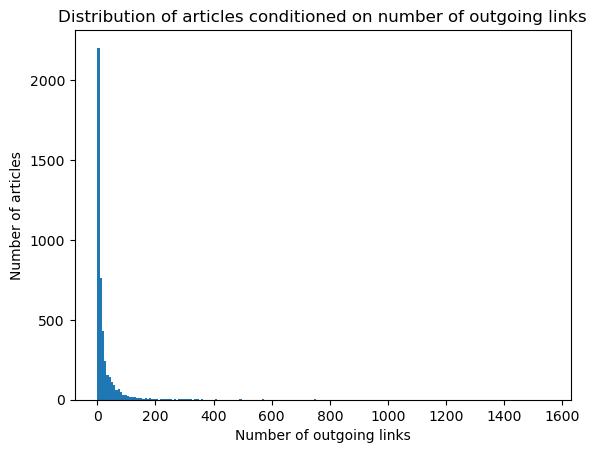

In [21]:
# see how many outgoing links each article has
outgoing_links = adj_matrix.apply(lambda a: a.sum(), axis = 0) # distribution of number of outgoing links per article
bins_300 = plt.hist(outgoing_links, bins = 200)
plt.xlabel("Number of outgoing links")
plt.ylabel("Number of articles")
plt.title("Distribution of articles conditioned on number of outgoing links")
plt.show()

In [22]:
outgoing_links.describe()

count    4604.000000
mean       26.038662
std        62.746827
min         0.000000
25%         2.000000
50%         8.000000
75%        25.000000
max      1551.000000
dtype: float64

In [23]:
(outgoing_links > 100).sum()

223

In [24]:
outgoing_links.value_counts().sort_index().head()

0    469
1    442
2    308
3    281
4    200
Name: count, dtype: int64

The dataset containts 469 articles that have 0 outgoing links. There is one article (outlier) that contains 1551 outgoing links.
The median of the number of outgoing links is 8.

We can see the distribution of number of outgoing links is skewed.

count    4135.000000
mean        2.342098
std         1.426441
min         0.000000
25%         1.386294
50%         2.302585
75%         3.367296
max         7.346655
dtype: float64


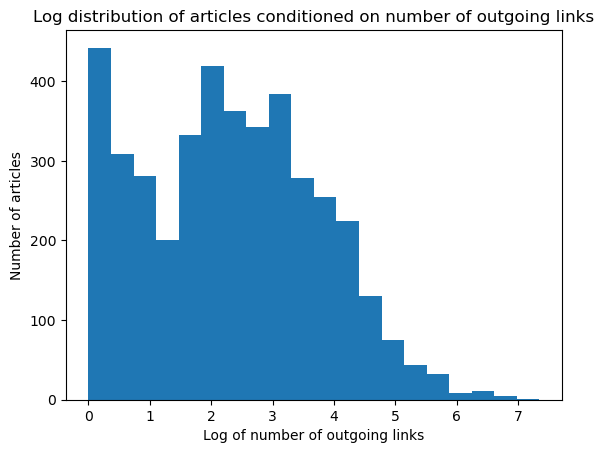

In [25]:
outgoing_links2 = adj_matrix.apply(lambda a: np.log(a.sum()) if a.sum() > 0 else None, axis = 0)
outgoing_links2.dropna(inplace=True)
print(outgoing_links2.describe())
plt.hist(outgoing_links2, bins = 20)
plt.xlabel("Log of number of outgoing links")
plt.ylabel("Number of articles")
plt.title("Log distribution of articles conditioned on number of outgoing links")
plt.show()

### Ingoing links

In [26]:
ingoing_links = adj_matrix.apply(lambda a: a.sum(), axis = 1)
ingoing_links.describe()

count    4604.000000
mean       26.038662
std        24.201491
min         0.000000
25%        11.000000
50%        19.000000
75%        33.000000
max       294.000000
dtype: float64

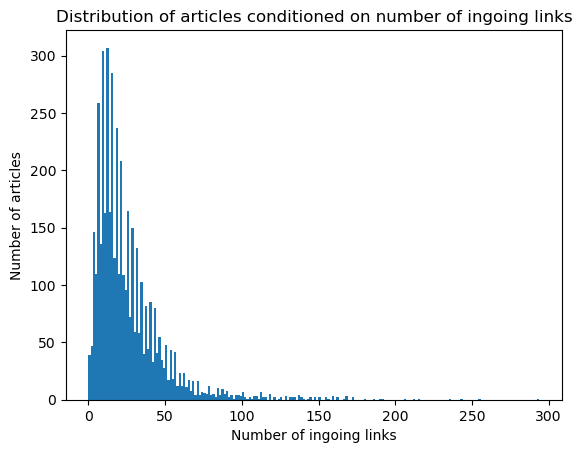

In [27]:
# see how many ingoing links each article has
plt.hist(ingoing_links, bins = 200)
plt.xlabel("Number of ingoing links")
plt.ylabel("Number of articles")
plt.title("Distribution of articles conditioned on number of ingoing links")
plt.show()

In [28]:
ingoing_links.value_counts().sort_index().head()

0    17
1    22
2    47
3    60
4    86
Name: count, dtype: int64

In [29]:
(ingoing_links > 100).sum()

87

The dataset contains 17 articles with 0 ingoing links.

223 articles have more than 100 outgoing links, while only 87 have more than 100 ingoing links.

In [30]:
all_links = pd.concat([ingoing_links, outgoing_links], axis = 1)
all_links.head()

,0,1
Áedán_mac_Gabráin,11,0
Åland,19,0
Édouard_Manet,20,0
Éire,8,0
Óengus_I_of_the_Picts,10,0


In [31]:
all_links[(all_links[0] == 0) & (all_links[1] == 0)]

,0,1
Badugi,0,0
Color_Graphics_Adapter,0,0
Donation,0,0
Douglas_DC-4,0,0
Lone_Wolf_(gamebooks),0,0
Private_Peaceful,0,0
Schatzki_ring,0,0
Suikinkutsu,0,0
Underground_(stories),0,0
Vacutainer,0,0


## Analysing shortest paths

In [32]:
distance_df.head()

,Áedán_mac_Gabráin,Åland,Édouard_Manet,Éire,Óengus_I_of_the_Picts,€2_commemorative_coins,10th_century,11th_century,12th_century,13th_century,...,Ziad_Jarrah,Zimbabwe,Zinc,Zinc_chloride,Zion_National_Park,Zionism,Zirconium,Zoroaster,Zuid-Gelders,Zulu
Áedán_mac_Gabráin,0.0,NaN,NaN,NaN,NaN,NaN,3.0,3.0,3.0,3.0,...,4.0,3.0,3.0,4.0,4.0,3.0,4.0,4.0,4.0,2.0
Åland,NaN,0.0,NaN,NaN,NaN,NaN,2.0,2.0,2.0,2.0,...,4.0,2.0,3.0,4.0,4.0,3.0,4.0,3.0,3.0,3.0
Édouard_Manet,NaN,NaN,0.0,NaN,NaN,NaN,3.0,3.0,2.0,2.0,...,4.0,3.0,2.0,3.0,4.0,3.0,4.0,3.0,3.0,3.0
Éire,NaN,NaN,NaN,0.0,NaN,NaN,3.0,3.0,3.0,3.0,...,4.0,2.0,2.0,3.0,4.0,3.0,4.0,4.0,3.0,3.0
Óengus_I_of_the_Picts,NaN,NaN,NaN,NaN,0.0,NaN,2.0,2.0,3.0,2.0,...,4.0,2.0,3.0,4.0,4.0,3.0,4.0,3.0,3.0,3.0


In [33]:
shortest_paths = distance_df.apply(lambda r: r.tolist(), axis = 1) # to each article, assign it a list of shortest path distances from other articles
shortest_paths.head()

Áedán_mac_Gabráin        [0.0, nan, nan, nan, nan, nan, 3.0, 3.0, 3.0, ...
Åland                    [nan, 0.0, nan, nan, nan, nan, 2.0, 2.0, 2.0, ...
Édouard_Manet            [nan, nan, 0.0, nan, nan, nan, 3.0, 3.0, 2.0, ...
Éire                     [nan, nan, nan, 0.0, nan, nan, 3.0, 3.0, 3.0, ...
Óengus_I_of_the_Picts    [nan, nan, nan, nan, 0.0, nan, 2.0, 2.0, 3.0, ...
dtype: object

In [34]:
num_nans = shortest_paths.apply(lambda a: sum(math.isnan(x) for x in a))
num_nans.describe()

count    4604.000000
mean      565.590139
std       259.920657
min       543.000000
25%       549.000000
50%       549.000000
75%       549.000000
max      4603.000000
dtype: float64

In [35]:
sum(num_nans.values)

2603977

In [36]:
print(f"{sum(num_nans.values)*100 / (articles_df.shape[0]**2)}% of possible missions defined by source and target article are unwinnable")

12.284755408548152% of possible missions defined by source and target article are unwinnable


There are 2603977 source-goal defined missions from all 21196816 (4604 * 4604) possible that are not winnable since there exist no shortest path from source to goal. They represent 12.28% of possible missions.

## Analysing finished paths

In [37]:
finished_df.head()

,hashIP,timestamp,duration,path,difficulty_rating,path_length,num_backward
0,6a3701d319fc3754,2011-02-15 03:26:49,166,"[14th_century, 15th_century, 16th_century, Pac...",NaN,9,0
1,3824310e536af032,2012-08-12 06:36:52,88,"[14th_century, Europe, Africa, Atlantic_slave_...",3.0,5,0
2,415612e93584d30e,2012-10-03 21:10:40,138,"[14th_century, Niger, Nigeria, British_Empire,...",NaN,8,0
3,64dd5cd342e3780c,2010-02-08 07:25:25,37,"[14th_century, Renaissance, Ancient_Greece, Gr...",NaN,4,0
4,015245d773376aab,2013-04-23 15:27:08,175,"[14th_century, Italy, Roman_Catholic_Church, H...",3.0,7,0


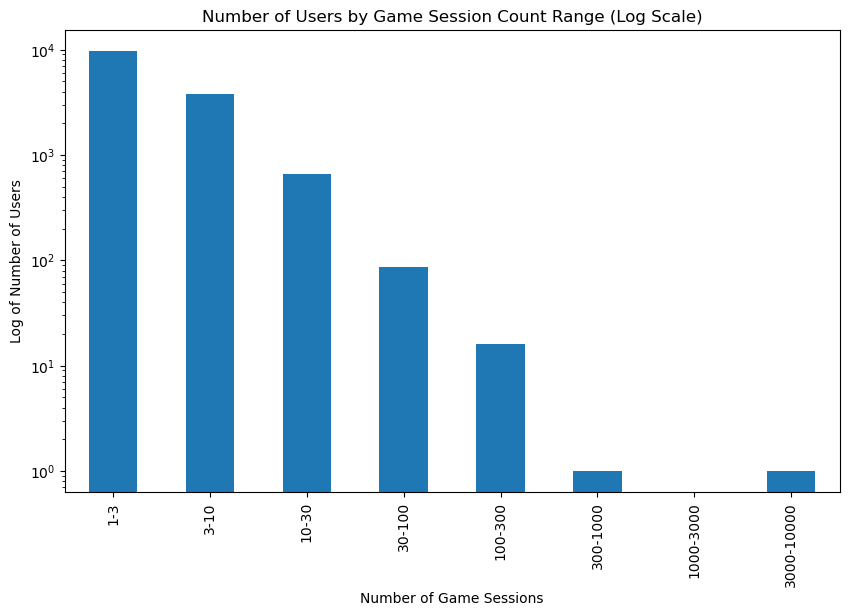

In [38]:
# Count the occurrences of each IP hash
ip_counts = finished_df['hashIP'].value_counts()

bins = [1, 3, 10, 30, 100, 300, 1000, 3000, 10000]
labels = ["1-3", "3-10", "10-30", "30-100", "100-300", "300-1000", "1000-3000", "3000-10000"]

# Cut the IP counts into the specified bins
ip_count_bins = pd.cut(ip_counts, bins=bins, labels=labels, right=False)

# Count the number of users (IPs) in each bin
user_count_per_bin = ip_count_bins.value_counts().sort_index()

# Plot the distribution of users per play frequency bin with log scale
plt.figure(figsize=(10, 6))
user_count_per_bin.plot(kind='bar', logy=True)
plt.title("Number of Users by Game Session Count Range (Log Scale)")
plt.xlabel("Number of Game Sessions")
plt.ylabel("Log of Number of Users")
plt.show()

### Path length

In [39]:
finished_df.path_length.describe()

count    51318.000000
mean         6.757434
std          4.680718
min          1.000000
25%          5.000000
50%          6.000000
75%          8.000000
max        435.000000
Name: path_length, dtype: float64

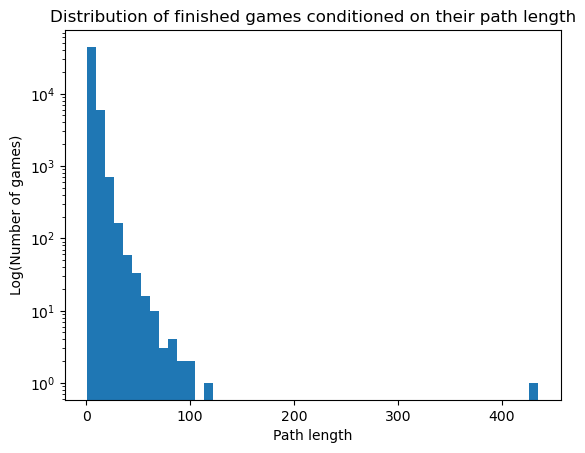

In [40]:
path_bin_50 = plt.hist(finished_df.path_length, log=True, bins=50)
plt.xlabel("Path length")
plt.ylabel("Log(Number of games)")
plt.title("Distribution of finished games conditioned on their path length")
plt.show()

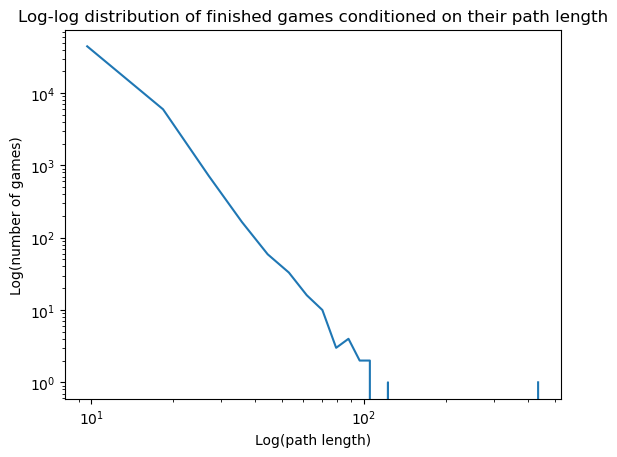

In [41]:
plt.loglog(path_bin_50[1][1:], path_bin_50[0])
plt.xlabel("Log(path length)")
plt.ylabel("Log(number of games)")
plt.title("Log-log distribution of finished games conditioned on their path length")
plt.show()

In [42]:
finished_df.path_length.value_counts().sort_index().head(20)

path_length
1        11
2       798
3      3424
4      8558
5     10941
6      8137
7      5868
8      3954
9      2650
10     1713
11     1256
12      867
13      623
14      462
15      359
16      275
17      232
18      183
19      151
20      119
Name: count, dtype: int64

We can see there are outliers, since the max is 435 and the mean is 6.75. We can also see the distribution is skewed.

### Backward option

In [43]:
finished_df.num_backward.describe()

count    51318.000000
mean         0.400659
std          1.451216
min          0.000000
25%          0.000000
50%          0.000000
75%          0.000000
max         45.000000
Name: num_backward, dtype: float64

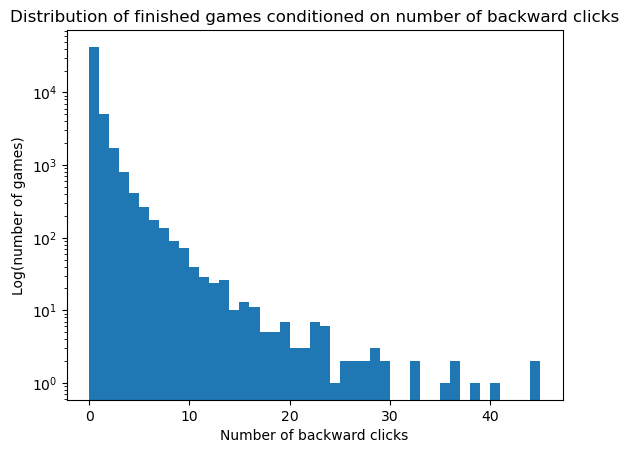

In [44]:
backward_45_bins = plt.hist(finished_df.num_backward, log=True, bins=45)
plt.xlabel("Number of backward clicks")
plt.ylabel("Log(number of games)")
plt.title("Distribution of finished games conditioned on number of backward clicks")
plt.show()

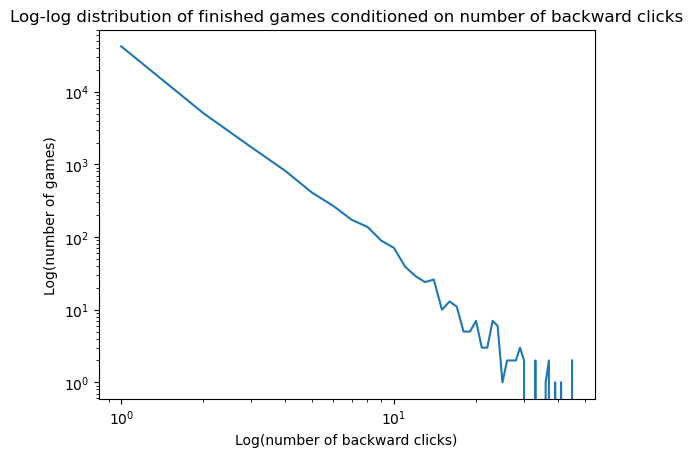

In [45]:
plt.loglog(backward_45_bins[1][1:], backward_45_bins[0])
plt.xlabel("Log(number of backward clicks)")
plt.ylabel("Log(number of games)")
plt.title("Log-log distribution of finished games conditioned on number of backward clicks")
plt.show()

In [46]:
finished_df.num_backward.value_counts().sort_index().head(20)

num_backward
0     42323
1      5095
2      1726
3       815
4       411
5       268
6       173
7       138
8        89
9        71
10       39
11       29
12       24
13       26
14       10
15       13
16       11
17        5
18        5
19        7
Name: count, dtype: int64

In [47]:
print("The backward option was not used at all in ", 100*finished_df.num_backward.value_counts().sort_index().iloc[0] / finished_df.shape[0] , " % of missions")

The backward option was not used at all in  82.4720371019915  % of missions


In most finished missions, the backward option was not used at all. The distribution of backward uses per mission is therefore also skewed. It resembles a proper power law distribution

### Duration

In [48]:
finished_df.duration.describe()

count    51318.000000
mean       158.276199
std        360.841904
min          0.000000
25%         60.000000
50%        107.000000
75%        183.000000
max      35091.000000
Name: duration, dtype: float64

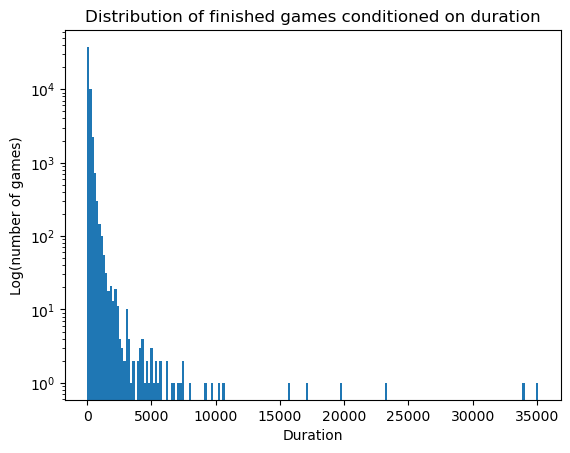

In [49]:
bins_200 = plt.hist(finished_df.duration, bins = 200, log=True)
plt.xlabel("Duration")
plt.ylabel("Log(number of games)")
plt.title("Distribution of finished games conditioned on duration")
plt.show()

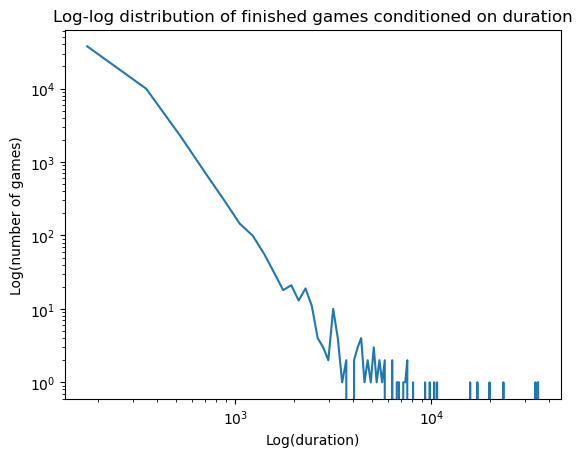

In [50]:
plt.loglog(bins_200[1][1:], bins_200[0])
plt.xlabel("Log(duration)")
plt.ylabel("Log(number of games)")
plt.title("Log-log distribution of finished games conditioned on duration")
plt.show()

In [51]:
short_walks = finished_df[finished_df['duration'] <= 3]
print(short_walks.shape)
print(short_walks['path_length'].unique())

short_walks.head()

(107, 7)
[2 3 1]


,hashIP,timestamp,duration,path,difficulty_rating,path_length,num_backward
731,321e4b101c5b58ff,2008-08-18 23:36:00,3,"[Archaeology, Anthropology]",1.0,2,0
1382,1d7a86e8252ac89d,2012-08-12 20:27:42,2,"[Batman, Superman]",NaN,2,0
1383,0dc49fcd7b52ef51,2012-09-18 21:40:26,3,"[Batman, Superman]",NaN,2,0
1384,7d5624e35c9523ef,2012-09-26 17:56:46,3,"[Batman, Superman]",NaN,2,0
1385,36691f800d571743,2012-11-13 20:15:07,2,"[Batman, Superman]",NaN,2,0


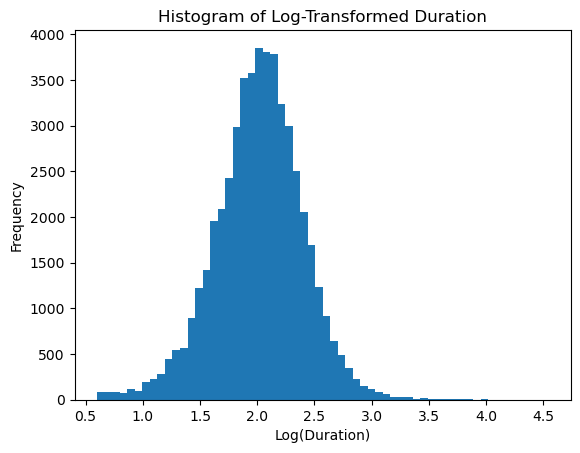

Shapiro-Wilk Test for Normality on Sampled Data:
Statistic: 0.9943970674107385, p-value: 0.06380634974613274


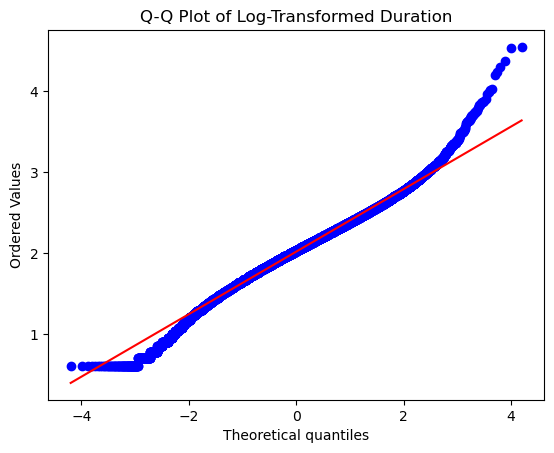

In [52]:
# Log transformation and keep only games with time > 3
log_duration = np.log10(finished_df[finished_df['duration'] > 3]['duration'])

# Histogram of log-transformed data
plt.hist(log_duration, bins=60)
plt.title("Histogram of Log-Transformed Duration")
plt.xlabel("Log(Duration)")
plt.ylabel("Frequency")
plt.show()

# Normality test (Shapiro-Wilk test)
NUM_OF_SAMPLES = 500
# Sample `NUM_OF_SAMPLES` points from the log-transformed duration data
sampled_log_duration = log_duration.sample(n=NUM_OF_SAMPLES, random_state=1)

# Perform the Shapiro-Wilk test on the sample
shapiro_test_sampled = stats.shapiro(sampled_log_duration)
print("Shapiro-Wilk Test for Normality on Sampled Data:")
print(f"Statistic: {shapiro_test_sampled.statistic}, p-value: {shapiro_test_sampled.pvalue}")

# Q-Q plot
plt.figure()
stats.probplot(log_duration, dist="norm", plot=plt)
plt.title("Q-Q Plot of Log-Transformed Duration")
plt.show()

The distribution is not exactly log normal but it is approximately

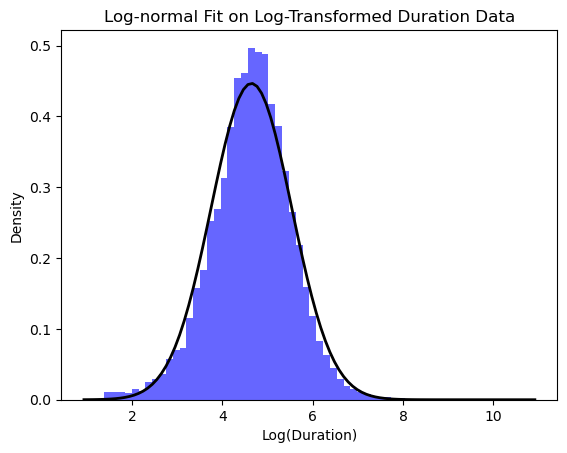

In [53]:
# Keep only games which have a duration > 3
cleaned_duration = finished_df['duration'][finished_df['duration'] > 3]

# Take the logarithm of the cleaned duration data
log_cleaned_duration = np.log(cleaned_duration)

# Fit a normal distribution to the log-transformed data
mu, sigma = stats.norm.fit(log_cleaned_duration)

# Plot the histogram of the log-transformed cleaned data
plt.hist(log_cleaned_duration, bins=60, density=True, alpha=0.6, color='b')

# Plot the PDF of the fitted log-normal distribution
xmin, xmax = plt.xlim()
x = np.linspace(xmin, xmax, 100)
p = stats.norm.pdf(x, mu, sigma)
plt.plot(x, p, 'k', linewidth=2)
plt.title("Log-normal Fit on Log-Transformed Duration Data")
plt.xlabel("Log(Duration)")
plt.ylabel("Density")
plt.show()

### Difficulty ratings

It is important to keep in mind that the given difficulty ratings are given by user who successfully finished the mission, and are not an objective difficulty measure.

In [54]:
finished_df.difficulty_rating.describe()

count    28501.000000
mean         2.269780
std          1.110439
min          1.000000
25%          1.000000
50%          2.000000
75%          3.000000
max          5.000000
Name: difficulty_rating, dtype: float64

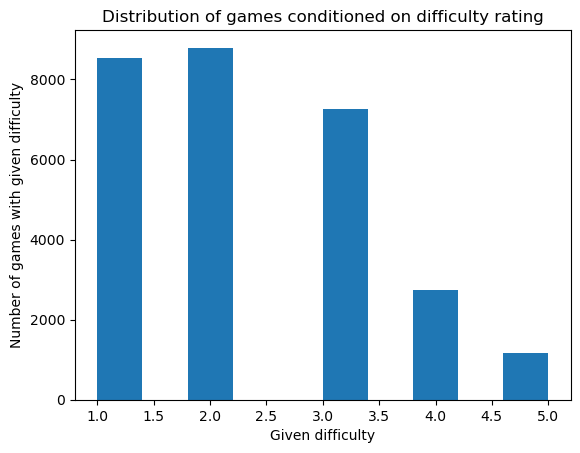

In [55]:
plt.hist(finished_df.difficulty_rating)
plt.xlabel("Given difficulty")
plt.ylabel("Number of games with given difficulty")
plt.title("Distribution of games conditioned on difficulty rating")
plt.show()

In [56]:
finished_df.difficulty_rating.value_counts().sort_index()

difficulty_rating
1.0    8542
2.0    8792
3.0    7261
4.0    2748
5.0    1158
Name: count, dtype: int64

In [57]:
print("Percentage of missing difficulty ratings: ", 100 * finished_df.difficulty_rating.isna().sum() / finished_df.difficulty_rating.shape, "%")

Percentage of missing difficulty ratings:  [44.46198215] %


We can see that in almost 45% of the cases, the user did not give a difficulty rating for the mission. Higher difficulty ratings are more rare.

### Correlations between path lenghts, duration, backward clicks and difficulty rating

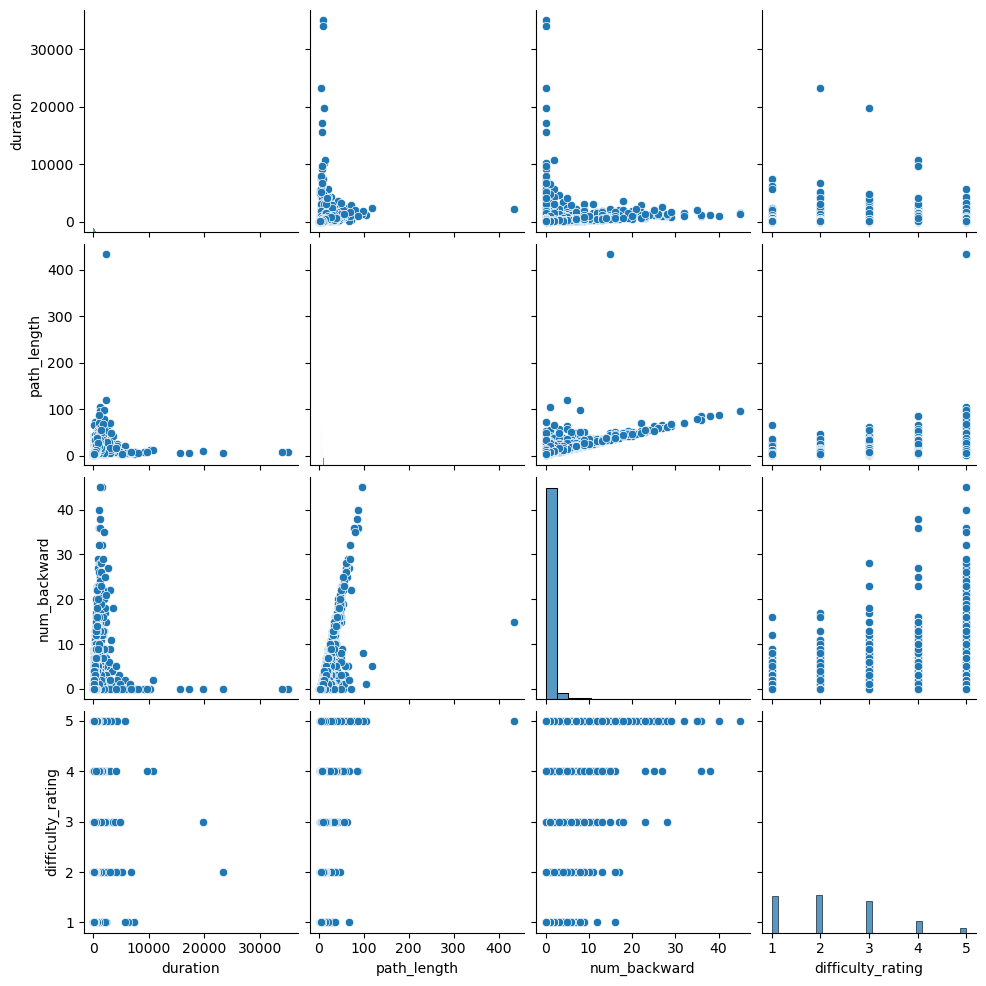

In [58]:
sns.pairplot(finished_df[['duration', 'path_length', 'num_backward', 'difficulty_rating']])
plt.show()

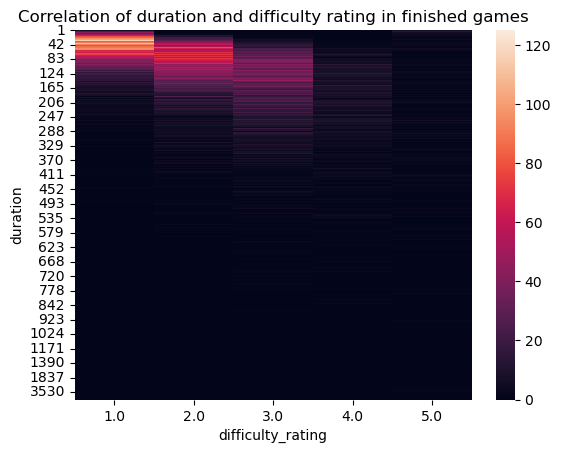

In [59]:
sns.heatmap(pd.crosstab(finished_df.duration, finished_df.difficulty_rating))
plt.title("Correlation of duration and difficulty rating in finished games")
plt.show()

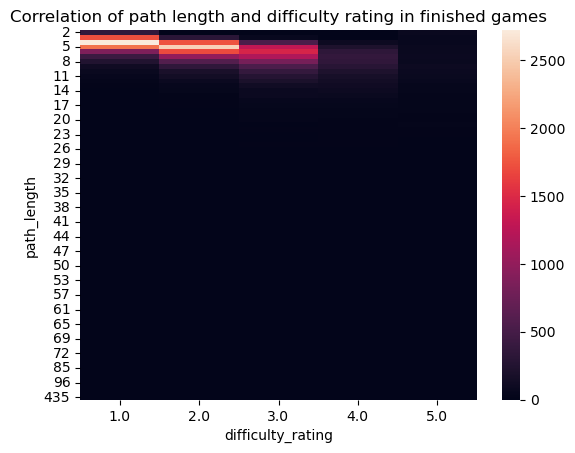

In [60]:
sns.heatmap(pd.crosstab(finished_df.path_length, finished_df.difficulty_rating))
plt.title("Correlation of path length and difficulty rating in finished games")
plt.show()

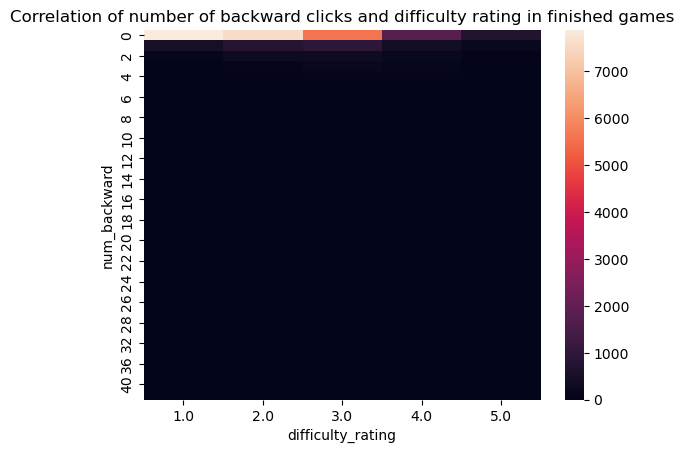

In [61]:
sns.heatmap(pd.crosstab(finished_df.num_backward, finished_df.difficulty_rating))
plt.title("Correlation of number of backward clicks and difficulty rating in finished games")
plt.show()

Ignoring the outliers, we can see a positive correlation between the difficulty rating and the duration and the path_length.

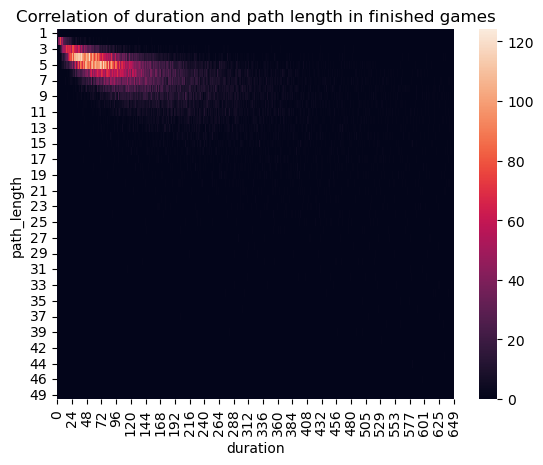

In [62]:
finished_df_copy = finished_df[(finished_df.path_length < 50) & (finished_df.duration < 650)]
sns.heatmap(pd.crosstab(finished_df_copy.path_length, finished_df_copy.duration))
plt.title("Correlation of duration and path length in finished games")
plt.show()

In [63]:
finished_df[['duration', 'path_length', 'difficulty_rating', 'num_backward']].corr(method = 'pearson')

,duration,path_length,difficulty_rating,num_backward
duration,1.000000,0.279051,0.253637,0.199282
path_length,0.279051,1.000000,0.403749,0.718316
difficulty_rating,0.253637,0.403749,1.000000,0.233722
num_backward,0.199282,0.718316,0.233722,1.000000


## Analysing unfinished paths

In [64]:
unfinished_df.head()

,hashIP,timestamp,duration,path,target_article,type_end,path_length,num_backward
0,2426091a53125110,2011-02-07 05:02:15,1804,[Obi-Wan_Kenobi],Microsoft,timeout,1,0
1,26141fd878806294,2011-02-07 05:14:11,1805,[Julius_Caesar],Caracas,timeout,1,0
2,2b015fb8181c48f2,2011-02-07 15:00:19,1818,"[Malawi, Democracy, Alexander_the_Great]",First_Crusade,timeout,3,0
3,53a53bc244e08a6a,2011-02-07 16:06:01,49,[Paraguay],Mount_St._Helens,restart,1,0
4,53a53bc244e08a6a,2011-02-07 17:18:25,1808,"[Paraguay, Bolivia]",Mount_St._Helens,timeout,2,0


### Path length

In [65]:
unfinished_df.path_length.describe()

count    24875.000000
mean         5.197789
std          5.772234
min          1.000000
25%          2.000000
50%          4.000000
75%          7.000000
max        235.000000
Name: path_length, dtype: float64

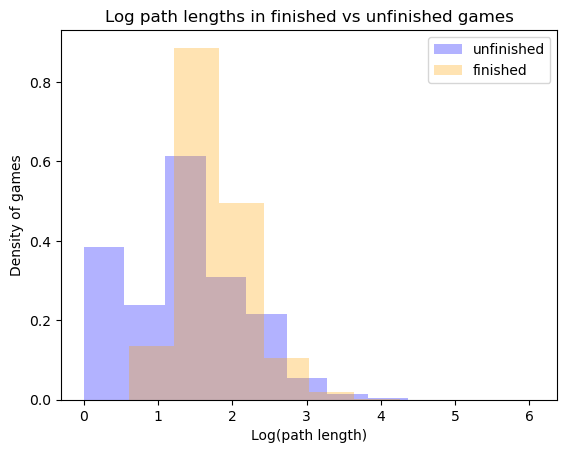

In [66]:
plt.hist(unfinished_df.path_length.apply(lambda a: np.log(a)), color = 'blue', label = 'unfinished',  alpha = 0.3, density = True)
plt.hist(finished_df.path_length.apply(lambda a: np.log(a)), color = 'orange', label = 'finished',  alpha = 0.3, density = True)
plt.legend()
plt.xlabel("Log(path length)")
plt.ylabel("Density of games")
plt.title("Log path lengths in finished vs unfinished games")
plt.show()

While the median in finished lengths for the path length was 6, here it is 4, which suggests unfinished paths are shorter.

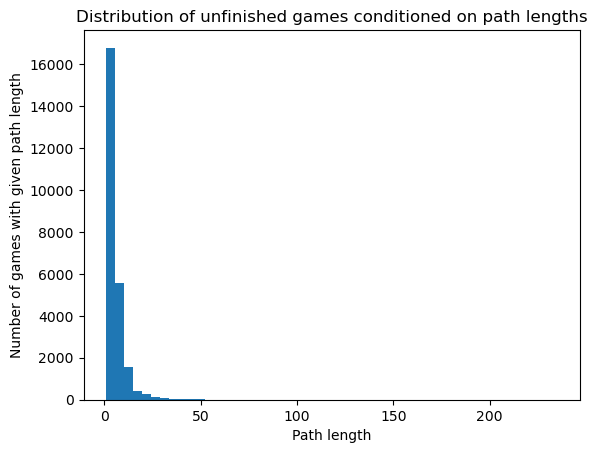

In [67]:
plt.hist(unfinished_df.path_length, bins = 50)
plt.xlabel("Path length")
plt.ylabel("Number of games with given path length")
plt.title("Distribution of unfinished games conditioned on path lengths")
plt.show()

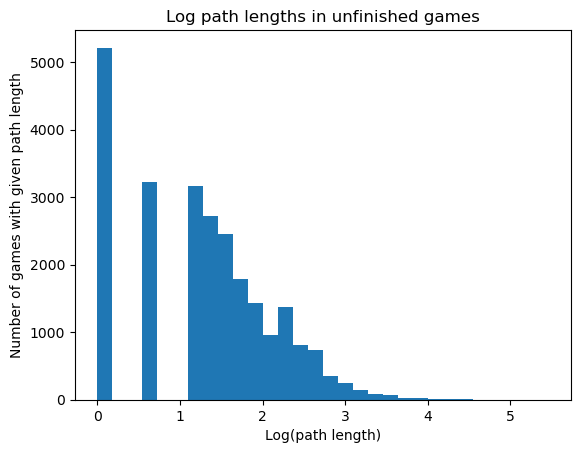

In [68]:
plt.hist(unfinished_df.path_length.apply(np.log), bins = 30)
plt.xlabel("Log(path length)")
plt.ylabel("Number of games with given path length")
plt.title("Log path lengths in unfinished games")
plt.show()

The path lengths are again coming from a skewed distribution.

### Backward option

In [69]:
unfinished_df.num_backward.describe()

count    24875.000000
mean         0.518874
std          1.821074
min          0.000000
25%          0.000000
50%          0.000000
75%          0.000000
max         82.000000
Name: num_backward, dtype: float64

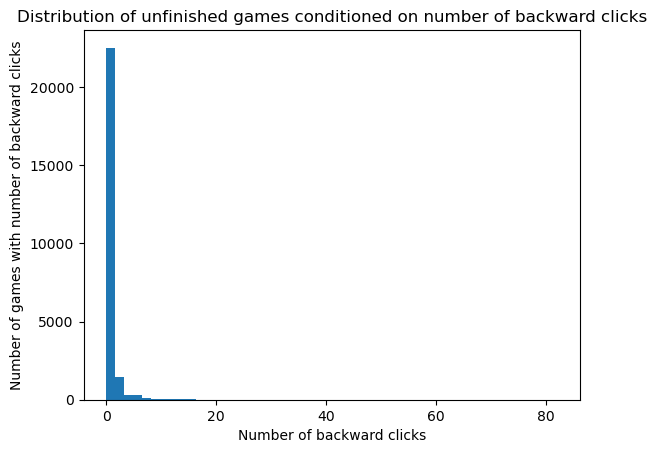

In [70]:
plt.hist(unfinished_df.num_backward, bins = 50)
plt.xlabel("Number of backward clicks")
plt.ylabel("Number of games with number of backward clicks")
plt.title("Distribution of unfinished games conditioned on number of backward clicks")
plt.show()

In [71]:
print("The backward option was not used at all in ", 100*unfinished_df.num_backward.value_counts().sort_index().iloc[0] / unfinished_df.shape[0] , " % of missions")

The backward option was not used at all in  79.09145728643216  % of missions


The backward option was used only 3% more than in finished paths.

### Type of end

In [72]:
unfinished_df.type_end.value_counts().sort_index()

type_end
restart    15552
timeout     9323
Name: count, dtype: int64

In [73]:
print("The game ends because of a restart in ", 100* unfinished_df[unfinished_df.type_end == 'restart'].shape[0] / unfinished_df.shape[0] , "% of cases")

The game ends because of a restart in  62.52060301507538 % of cases


The game can end either because of a timeout, or because the player restarted the game.

### Duration

In [74]:
unfinished_df.duration.describe()

count    24875.000000
mean       835.296884
std        881.287961
min          4.000000
25%         86.000000
50%        261.000000
75%       1831.000000
max       9089.000000
Name: duration, dtype: float64

The duration in unfinished paths is significantly bigger than in finished paths, with a 75th percentile of 1831 seconds, compared to the previous of 183.

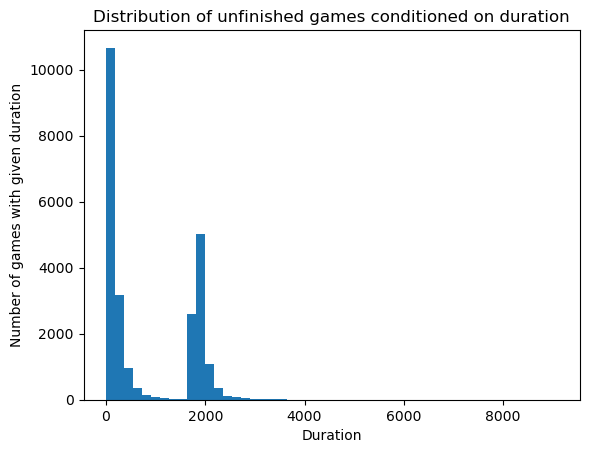

In [75]:
plt.hist(unfinished_df.duration, bins = 50)
plt.xlabel("Duration")
plt.ylabel("Number of games with given duration")
plt.title("Distribution of unfinished games conditioned on duration")
plt.show()

We notice two clusters of unfinished games depending on the duration.

However, we have to take into account that over 35% of unfinished missions ended in a timeout, so the duration in these cases is not relevant. We therefore analyse the duration again, removing the rows that ended in a timeout

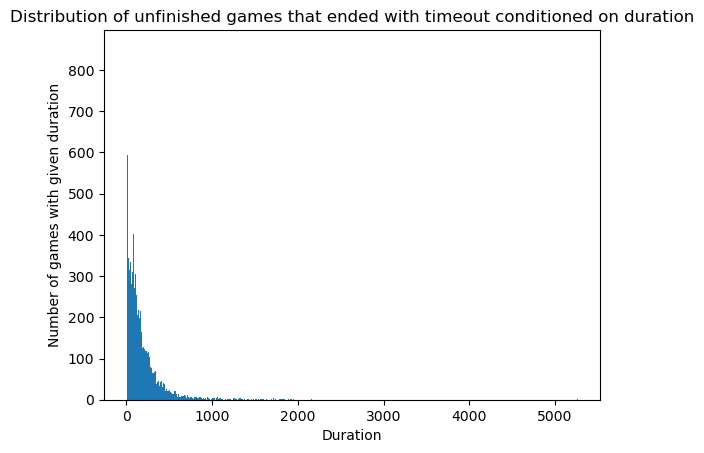

In [76]:
ended_restart = unfinished_df[unfinished_df.type_end == 'restart']
plt.hist(ended_restart.duration, bins = 1000)
plt.xlabel("Duration")
plt.ylabel("Number of games with given duration")
plt.title("Distribution of unfinished games that ended with timeout conditioned on duration")
plt.show()

In [77]:
ended_restart.duration.describe()

count    15552.000000
mean       176.575296
std        222.267962
min          4.000000
25%         48.000000
50%        114.000000
75%        224.000000
max       5263.000000
Name: duration, dtype: float64

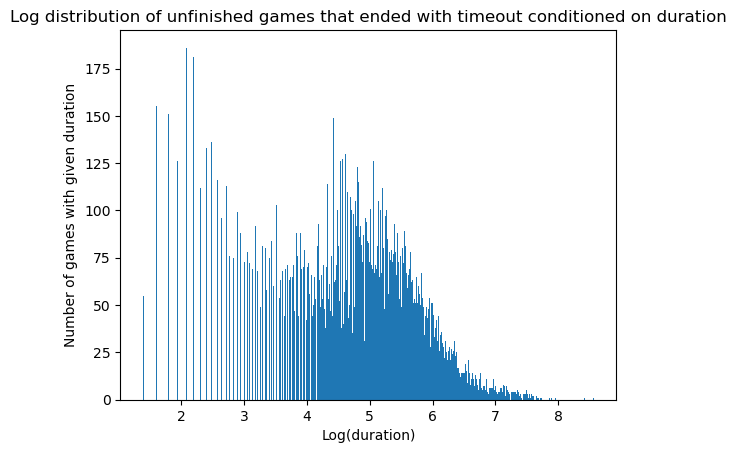

In [78]:
plt.hist(ended_restart.duration.apply(np.log), bins = 500)
plt.xlabel("Log(duration)")
plt.ylabel("Number of games with given duration")
plt.title("Log distribution of unfinished games that ended with timeout conditioned on duration")
plt.show()

The duration is shorter for the 25th percentile (it was 60 seconds before), but is bigger for the 75th percentile (was 183 before).

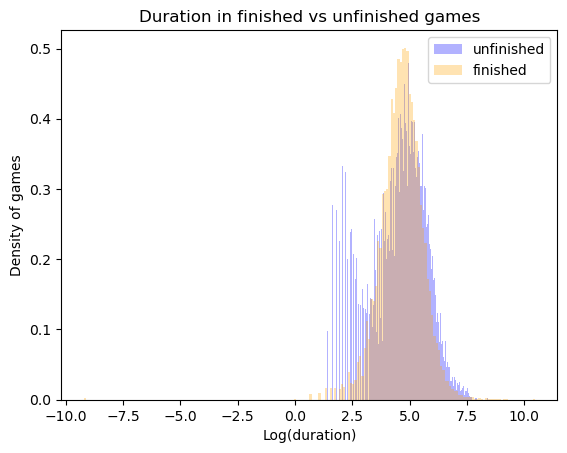

In [79]:
plt.hist(ended_restart.duration.apply(lambda a: np.log(a + 1e-4)), color = 'blue', label = 'unfinished', bins = 200, alpha = 0.3, density = True)
plt.hist(finished_df.duration.apply(lambda a: np.log(a + 1e-4)), color = 'orange', label = 'finished', bins = 200, alpha = 0.3, density = True)
plt.legend()
plt.xlabel("Log(duration)")
plt.ylabel("Density of games")
plt.title("Duration in finished vs unfinished games")
plt.show()

### Correlation between duration, path length and backward option

We will only consider rows that ended by a restart so that we make sure the duration is relevant.

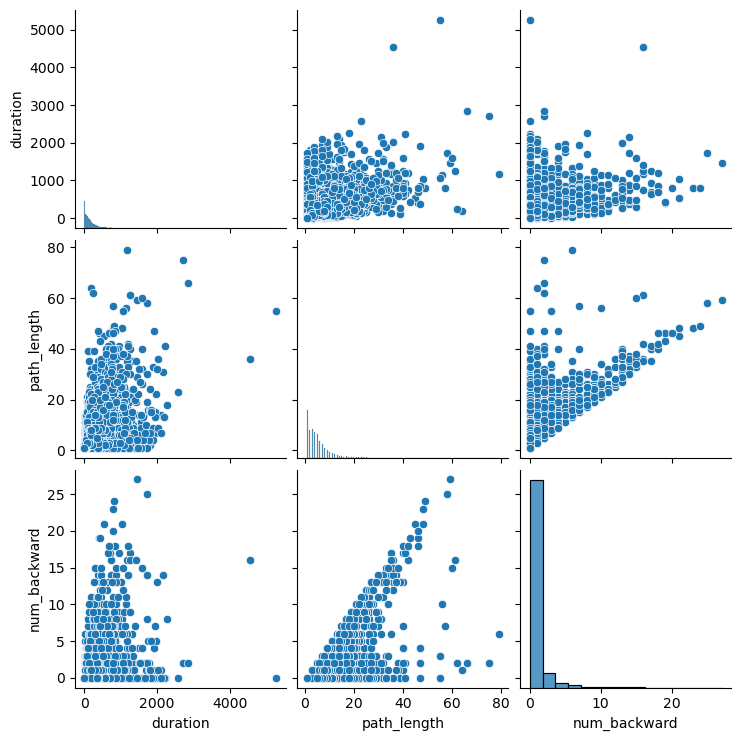

In [80]:
sns.pairplot(ended_restart[['duration', 'path_length', 'num_backward', 'type_end']])
plt.show()

In [81]:
ended_restart[['duration', 'path_length', 'num_backward']].corr(method = 'pearson')

,duration,path_length,num_backward
duration,1.000000,0.609426,0.353296
path_length,0.609426,1.000000,0.684169
num_backward,0.353296,0.684169,1.000000


We see a higher correlation than before between the path length and the duration and between the path length and the number of backward clicks.

## Analysing missions 

Our goal is to analyse the distribution of played missions depending on source and goal article, if the difficulty rating depends more on the player or on the source/goal article, how much data we have for each source/goal pair etc

In [82]:
print(unfinished_df.head())
print(finished_df.head())

             hashIP           timestamp  duration  \
0  2426091a53125110 2011-02-07 05:02:15      1804   
1  26141fd878806294 2011-02-07 05:14:11      1805   
2  2b015fb8181c48f2 2011-02-07 15:00:19      1818   
3  53a53bc244e08a6a 2011-02-07 16:06:01        49   
4  53a53bc244e08a6a 2011-02-07 17:18:25      1808   

                                       path    target_article type_end  \
0                          [Obi-Wan_Kenobi]         Microsoft  timeout   
1                           [Julius_Caesar]           Caracas  timeout   
2  [Malawi, Democracy, Alexander_the_Great]     First_Crusade  timeout   
3                                [Paraguay]  Mount_St._Helens  restart   
4                       [Paraguay, Bolivia]  Mount_St._Helens  timeout   

   path_length  num_backward  
0            1             0  
1            1             0  
2            3             0  
3            1             0  
4            2             0  
             hashIP           timestamp  duration 

In [83]:
print(unfinished_df['timestamp'].min())
print(finished_df['timestamp'].min())

2011-02-07 05:02:15
2008-08-18 21:29:32


We notice that the first unfinished game was recorded only two and a half years later than the first finished game. This makes us believe unfinished games were not recorded until February 2011. This can be a problem in our future analyses since we will rely on the winrate of certain missions, that will appear way bigger than it should since losses of these missions were not recorded. For that reason, we decide to discard for now the wins that happened before the first recorded loss.

In [84]:
unfinished_mod = unfinished_df.copy()
unfinished_mod['source_article'] = unfinished_mod.path.apply(lambda a: a[0])
unfinished_mod['finished'] = False
unfinished_mod = unfinished_mod.reindex(sorted(unfinished_mod.columns), axis=1)
unfinished_mod.head()
#unfinished_mod.shape[0]

,duration,finished,hashIP,num_backward,path,path_length,source_article,target_article,timestamp,type_end
0,1804,False,2426091a53125110,0,[Obi-Wan_Kenobi],1,Obi-Wan_Kenobi,Microsoft,2011-02-07 05:02:15,timeout
1,1805,False,26141fd878806294,0,[Julius_Caesar],1,Julius_Caesar,Caracas,2011-02-07 05:14:11,timeout
2,1818,False,2b015fb8181c48f2,0,"[Malawi, Democracy, Alexander_the_Great]",3,Malawi,First_Crusade,2011-02-07 15:00:19,timeout
3,49,False,53a53bc244e08a6a,0,[Paraguay],1,Paraguay,Mount_St._Helens,2011-02-07 16:06:01,restart
4,1808,False,53a53bc244e08a6a,0,"[Paraguay, Bolivia]",2,Paraguay,Mount_St._Helens,2011-02-07 17:18:25,timeout


In [85]:
finished_mod = finished_df.copy()
finished_mod = finished_mod[finished_mod['timestamp'] > unfinished_df['timestamp'].min()]
finished_mod['source_article'] = finished_mod.path.apply(lambda a: a[0])
finished_mod['target_article'] = finished_mod.path.apply(lambda a: a[-1])
finished_mod['finished'] = True
finished_mod = finished_mod.reindex(sorted(finished_mod.columns), axis=1)
finished_mod.head()
#finished_mod.shape[0]

,difficulty_rating,duration,finished,hashIP,num_backward,path,path_length,source_article,target_article,timestamp
0,NaN,166,True,6a3701d319fc3754,0,"[14th_century, 15th_century, 16th_century, Pac...",9,14th_century,African_slave_trade,2011-02-15 03:26:49
1,3.0,88,True,3824310e536af032,0,"[14th_century, Europe, Africa, Atlantic_slave_...",5,14th_century,African_slave_trade,2012-08-12 06:36:52
2,NaN,138,True,415612e93584d30e,0,"[14th_century, Niger, Nigeria, British_Empire,...",8,14th_century,African_slave_trade,2012-10-03 21:10:40
4,3.0,175,True,015245d773376aab,0,"[14th_century, Italy, Roman_Catholic_Church, H...",7,14th_century,John_F._Kennedy,2013-04-23 15:27:08
5,NaN,110,True,5295bca242be81fe,0,"[14th_century, Europe, North_America, United_S...",6,14th_century,John_F._Kennedy,2013-07-03 22:26:54


In [86]:
# creating dataframe combining stats about finished and unfinished missions
games = pd.concat([finished_mod, unfinished_mod], ignore_index = True)
games.head()
#games.shape[0]

,difficulty_rating,duration,finished,hashIP,num_backward,path,path_length,source_article,target_article,timestamp,type_end
0,NaN,166,True,6a3701d319fc3754,0,"[14th_century, 15th_century, 16th_century, Pac...",9,14th_century,African_slave_trade,2011-02-15 03:26:49,NaN
1,3.0,88,True,3824310e536af032,0,"[14th_century, Europe, Africa, Atlantic_slave_...",5,14th_century,African_slave_trade,2012-08-12 06:36:52,NaN
2,NaN,138,True,415612e93584d30e,0,"[14th_century, Niger, Nigeria, British_Empire,...",8,14th_century,African_slave_trade,2012-10-03 21:10:40,NaN
3,3.0,175,True,015245d773376aab,0,"[14th_century, Italy, Roman_Catholic_Church, H...",7,14th_century,John_F._Kennedy,2013-04-23 15:27:08,NaN
4,NaN,110,True,5295bca242be81fe,0,"[14th_century, Europe, North_America, United_S...",6,14th_century,John_F._Kennedy,2013-07-03 22:26:54,NaN


In [87]:
# creating dataframe that gives number of played games for each possible source/goal combination that was played at least one
count_missions = games.groupby(['source_article', 'target_article']).size() 

In [88]:
count_missions.describe()

count    29861.000000
mean         1.611466
std         21.033118
min          1.000000
25%          1.000000
50%          1.000000
75%          1.000000
max       2044.000000
dtype: float64

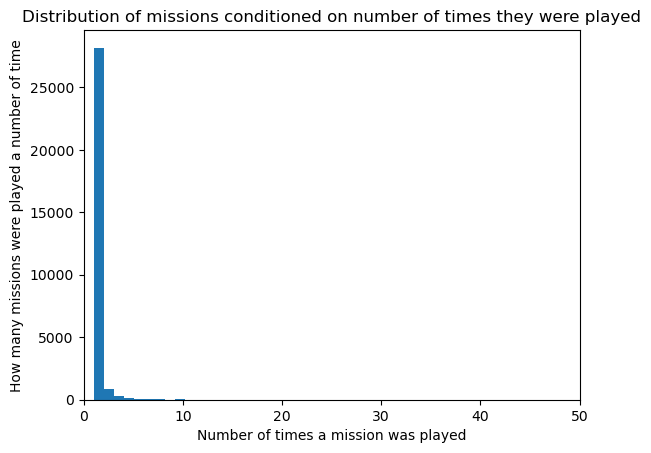

In [89]:
plt.hist(count_missions, bins = 2000)
plt.xlim(0, 50)
plt.xlabel("Number of times a mission was played")
plt.ylabel("How many missions were played a number of time")
plt.title("Distribution of missions conditioned on number of times they were played")
plt.show()

In [90]:
100*count_missions[count_missions > 10].count() / count_missions.shape[0] # % of missions played more than 10 times

0.4152573590971501

In [91]:
100 * (count_missions[(count_missions == 1) | (count_missions == 2)].count() )/ count_missions.shape[0] # % of missions played once or twice

94.34044405746626

Of all pairs of (source, goal) articles (possible missions),  94.34% have been played once or twice only. Less than 1% of missions were played more than 10 times.

### Number of played missions by player

In [92]:
player_countM = games.groupby('hashIP').size() # analysing number of missions per player
player_countM.head()

hashIP
000386124f307de8    2
0007183207b6008f    3
000a5bac5b7781ea    1
000a6e585b776c96    1
000d397013f09039    2
dtype: int64

In [93]:
player_countM.describe()

count    13765.000000
mean         3.495823
std         10.126428
min          1.000000
25%          1.000000
50%          2.000000
75%          3.000000
max        637.000000
dtype: float64

In [94]:
100*player_countM[player_countM > 5].count() / player_countM.count()

13.628768616055213

13% of players have played more than 5 games.

### Smarter way to identify players

Until now, we assumed each hashed IP address corresponds to a player. This assumption may not be correct as IP addresses change over time and depending on the location, and most of the players of Wikispeedia probably played it at the EPFL campus. Let's analyse how many games were played depending on the date.

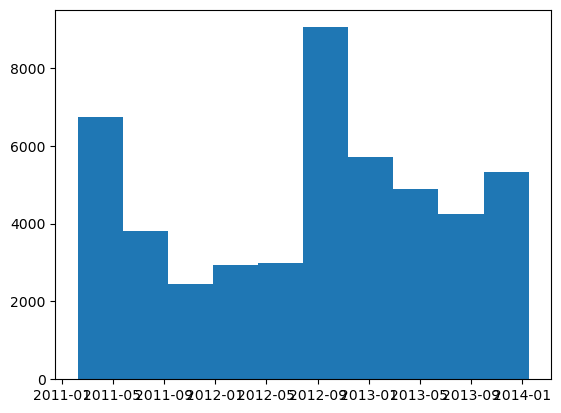

In [95]:
plt.hist(games['timestamp'])
plt.show()

In [96]:
games.groupby(pd.Grouper(key='timestamp', freq='D')).size().describe()

count    1074.000000
mean       44.804469
std        45.089028
min         0.000000
25%        20.000000
50%        34.000000
75%        55.000000
max       628.000000
dtype: float64

We can see there was one day where 628 games were played, let's see how many different hashIPs played that day.

In [97]:
games_count_by_day = games.groupby(pd.Grouper(key='timestamp', freq='D')).size()
games_count_by_day.head(10)

timestamp
2011-02-07    14
2011-02-08    40
2011-02-09    55
2011-02-10    31
2011-02-11    66
2011-02-12    50
2011-02-13    39
2011-02-14    49
2011-02-15    29
2011-02-16    30
Freq: D, dtype: int64

In [98]:
games[games['timestamp'].dt.date == (games_count_by_day[games_count_by_day == 628].index[0].date())]['hashIP'].nunique()

219

For this particular data and number of played games and different hashIPs, it is possible to assume that each hashIP corresponds to only one player, since this would assume players played on average 2-3 games (normal amount).

To further check if one hashIP corresponds to one player, let's see how are games of players that played more than 5 games distributed over time. We will first look at the difference in time between the first and last played game.

In [99]:
diff_first_last = games[games['hashIP'].isin(player_countM[player_countM > 5].index.tolist())].groupby('hashIP')['timestamp'].apply(lambda a: a.max() - a.min())
diff_first_last.describe()

count                          1876
mean     26 days 08:24:59.870469083
std      95 days 12:04:45.253492399
min                 0 days 00:02:09
25%          0 days 00:39:07.750000
50%          0 days 01:11:51.500000
75%                 1 days 20:48:56
max               953 days 03:35:01
Name: timestamp, dtype: object

In [100]:
100 * diff_first_last[diff_first_last > pd.Timedelta("30 days")].size / diff_first_last.size

11.620469083155651

11% of hashIPs have a difference bigger than 30 days between their first and last game. Let's see how the differences in times between any consecutive games of a player vary.

In [101]:
diff_max_any = games[games['hashIP'].isin(player_countM[player_countM > 5].index.tolist())].groupby('hashIP')['timestamp'].apply(lambda a: a.sort_values().diff().max())
diff_max_any.describe()

count                          1876
mean     19 days 18:55:21.289978678
std      73 days 17:49:46.617395360
min                 0 days 00:01:13
25%          0 days 00:14:49.500000
50%                 0 days 00:34:18
75%          1 days 04:33:54.750000
max               952 days 06:52:47
Name: timestamp, dtype: object

In [102]:
100 * diff_max_any[diff_max_any > pd.Timedelta("30 days")].size / diff_max_any.size

10.447761194029852

10.5% of hashIPs have had a break of at least 30 days between 2 games they played.

In [103]:
diff_max_any = games[games['hashIP'].isin(player_countM[player_countM > 5].index.tolist())].groupby('hashIP')['timestamp'].apply(lambda a: a.sort_values().diff())
print(diff_max_any.head())
diff_more_30 = diff_max_any.apply(lambda a: (a > pd.Timedelta("30 days")))
diff_more_30 = diff_more_30.reset_index()
diff_more_30 = diff_more_30.groupby('hashIP').sum()
diff_more_30['timestamp'].describe()

hashIP                 
00381d0a21b8ba73  40317               NaT
                  16221   0 days 00:02:42
                  4874    0 days 00:01:44
                  14288   0 days 00:10:13
                  19698   0 days 00:12:54
Name: timestamp, dtype: timedelta64[ns]


count    1876.000000
mean        0.159915
std         0.570392
min         0.000000
25%         0.000000
50%         0.000000
75%         0.000000
max         8.000000
Name: timestamp, dtype: float64

Most hashIPs don't have breaks bigger than 30 days, and the maximum number of breaks of 30 days between games is for a hashIP that had 8 breaks. From now on, if 2 games were played with the same hashIP but have a time difference of at least 30 days between when they were played, we will consider this as 2 different players. Since we want to use hashIP to identify players, we have to compute new unique hashIPs for the games where this is the case.

In [104]:
diff_max_any = games.groupby('hashIP')['timestamp'].apply(lambda a: a.sort_values().diff())
diff_max_any = diff_max_any.reset_index()
diff_max_any['game_no'] = diff_max_any.groupby('hashIP').cumcount()
diff_max_any.head(20)

,hashIP,level_1,timestamp,game_no
0,000386124f307de8,20318,NaT,0
1,000386124f307de8,36980,0 days 00:30:23,1
2,0007183207b6008f,13468,NaT,0
3,0007183207b6008f,12469,0 days 00:01:51,1
4,0007183207b6008f,17570,0 days 00:01:10,2
5,000a5bac5b7781ea,15052,NaT,0
6,000a6e585b776c96,25011,NaT,0
7,000d397013f09039,5974,NaT,0
8,000d397013f09039,6627,0 days 00:02:50,1
9,000e5d4c2c8e921f,2832,NaT,0


In [105]:
def generate_new_players(df, max_diff=pd.Timedelta("30 days")):
    new_hashIP = df['hashIP'].iloc[0] # starting hashIP
    current_suffix = 0
    new_hashIPs = []

    # give new haship to rows which have more than 30days diff compared to previous one
    for i, row in df.iterrows():
        if i > 0 and pd.notna(row['timestamp']) and row['timestamp'] > max_diff:
            current_suffix += 1
        new_hashIPs.append(f"{new_hashIP}_{current_suffix}")
    
    return new_hashIPs

new_hashIPs = diff_max_any.groupby('hashIP')[['hashIP', 'timestamp']].apply(generate_new_players)

In [106]:
new_hashIPs.head()

hashIP
000386124f307de8             [000386124f307de8_0, 000386124f307de8_0]
0007183207b6008f    [0007183207b6008f_0, 0007183207b6008f_0, 00071...
000a5bac5b7781ea                                 [000a5bac5b7781ea_0]
000a6e585b776c96                                 [000a6e585b776c96_0]
000d397013f09039             [000d397013f09039_0, 000d397013f09039_0]
dtype: object

In [107]:
for old, new in new_hashIPs.items():
    mask = games['hashIP'] == old
    games.loc[mask, 'newhashIP'] = new

games.head(20)

,difficulty_rating,duration,finished,hashIP,num_backward,path,path_length,source_article,target_article,timestamp,type_end,newhashIP
0,NaN,166,True,6a3701d319fc3754,0,"[14th_century, 15th_century, 16th_century, Pac...",9,14th_century,African_slave_trade,2011-02-15 03:26:49,NaN,6a3701d319fc3754_0
1,3.0,88,True,3824310e536af032,0,"[14th_century, Europe, Africa, Atlantic_slave_...",5,14th_century,African_slave_trade,2012-08-12 06:36:52,NaN,3824310e536af032_0
2,NaN,138,True,415612e93584d30e,0,"[14th_century, Niger, Nigeria, British_Empire,...",8,14th_century,African_slave_trade,2012-10-03 21:10:40,NaN,415612e93584d30e_0
3,3.0,175,True,015245d773376aab,0,"[14th_century, Italy, Roman_Catholic_Church, H...",7,14th_century,John_F._Kennedy,2013-04-23 15:27:08,NaN,015245d773376aab_0
4,NaN,110,True,5295bca242be81fe,0,"[14th_century, Europe, North_America, United_S...",6,14th_century,John_F._Kennedy,2013-07-03 22:26:54,NaN,5295bca242be81fe_0
5,2.0,387,True,03dc907932cecfc5,5,"[14th_century, Europe, Republic_of_Ireland, <,...",15,14th_century,Rainbow,2012-05-08 00:17:43,NaN,03dc907932cecfc5_0
6,3.0,179,True,134f295f1ad990fa,0,"[14th_century, English_peasants'_revolt_of_138...",10,14th_century,Rainbow,2012-07-18 08:29:34,NaN,134f295f1ad990fa_0
7,NaN,169,True,5339656423a6ba18,0,"[14th_century, India, Rice, Rain, Acid_rain, C...",8,14th_century,Rainbow,2012-08-02 20:46:44,NaN,5339656423a6ba18_0
8,NaN,246,True,46021cc81bd7069a,3,"[14th_century, Time, Physics, <, Day, Sun, Sun...",14,14th_century,Rainbow,2012-08-02 20:47:59,NaN,46021cc81bd7069a_0
9,3.0,345,True,28bd91e879d8ea9d,0,"[14th_century, France, World_War_II, Nuclear_w...",8,14th_century,Rainbow,2012-08-13 11:03:45,NaN,28bd91e879d8ea9d_0


Let's check if everything is alright by looking at the hashIP that had 8 breaks of more than 30 days.

In [108]:
diff_more_30[(diff_more_30['timestamp'] == 8) & pd.notna(diff_more_30['timestamp'])]

,level_1,timestamp
hashIP,,
0d48edb81fbc5911,2663948,8


The time differences between games for that hashIP were like this:

In [109]:
diff_max_any[diff_max_any['hashIP'] == '0d48edb81fbc5911']

,hashIP,level_1,timestamp,game_no
4753,0d48edb81fbc5911,7746,NaT,0
4754,0d48edb81fbc5911,27077,41 days 01:54:39,1
4755,0d48edb81fbc5911,27078,0 days 00:03:16,2
4756,0d48edb81fbc5911,13254,29 days 19:19:25,3
4757,0d48edb81fbc5911,7904,0 days 00:04:23,4
4758,0d48edb81fbc5911,10240,0 days 00:04:27,5
4759,0d48edb81fbc5911,27660,0 days 00:45:32,6
4760,0d48edb81fbc5911,27661,0 days 01:51:48,7
4761,0d48edb81fbc5911,27662,0 days 00:03:23,8
4762,0d48edb81fbc5911,10622,0 days 00:04:39,9


Let's see the new hashIPs for those games.

In [110]:
help_df = diff_max_any[diff_max_any['hashIP'] == '0d48edb81fbc5911'].copy().reset_index()[['hashIP', 'timestamp', 'game_no']]
help_df['newhashIP'] = games[games['hashIP'] == '0d48edb81fbc5911']['newhashIP'].reset_index(drop = True)
help_df

,hashIP,timestamp,game_no,newhashIP
0,0d48edb81fbc5911,NaT,0,0d48edb81fbc5911_0
1,0d48edb81fbc5911,41 days 01:54:39,1,0d48edb81fbc5911_1
2,0d48edb81fbc5911,0 days 00:03:16,2,0d48edb81fbc5911_1
3,0d48edb81fbc5911,29 days 19:19:25,3,0d48edb81fbc5911_1
4,0d48edb81fbc5911,0 days 00:04:23,4,0d48edb81fbc5911_1
5,0d48edb81fbc5911,0 days 00:04:27,5,0d48edb81fbc5911_1
6,0d48edb81fbc5911,0 days 00:45:32,6,0d48edb81fbc5911_1
7,0d48edb81fbc5911,0 days 01:51:48,7,0d48edb81fbc5911_1
8,0d48edb81fbc5911,0 days 00:03:23,8,0d48edb81fbc5911_1
9,0d48edb81fbc5911,0 days 00:04:39,9,0d48edb81fbc5911_1


So, from now on, the games dataframe has an additional newhashIP column we can use as another way to detect players.

In [111]:
player_countM2 = games.groupby('newhashIP').size() # analysing number of missions per player
print(player_countM2.describe())
print(100*player_countM2[player_countM2 > 5].count() / player_countM2.count())

count    14167.000000
mean         3.396626
std          9.207831
min          1.000000
25%          1.000000
50%          2.000000
75%          3.000000
max        579.000000
dtype: float64
13.36203854026964


13.36% of players have played more than 5 games. We know have 14167 players, which is a larger number than before (13765). The new max number of games played by a player is now 579. Let's analyse the time difference between his games.

In [112]:
player_countM2[player_countM2 == 579]

newhashIP
473d6ac602c2b198_0    579
dtype: int64

In [113]:
diff_max_any[diff_max_any['hashIP'] == '473d6ac602c2b198'].head()

,hashIP,level_1,timestamp,game_no
26347,473d6ac602c2b198,13572,NaT,0
26348,473d6ac602c2b198,8011,0 days 00:01:36,1
26349,473d6ac602c2b198,13400,0 days 00:07:07,2
26350,473d6ac602c2b198,5756,0 days 00:04:50,3
26351,473d6ac602c2b198,21606,0 days 00:02:08,4


In [114]:
temp = games[games['newhashIP'] == '473d6ac602c2b198_0'].copy()[['path_length']].reset_index()
temp['timediffs'] = diff_max_any[diff_max_any['hashIP'] == '473d6ac602c2b198'].copy().reset_index()['timestamp']
temp.head(30)

,index,path_length,timediffs
0,207,14,NaT
1,286,12,0 days 00:01:36
2,324,6,0 days 00:07:07
3,359,8,0 days 00:04:50
4,364,30,0 days 00:02:08
5,397,5,0 days 00:01:42
6,546,30,0 days 00:02:43
7,560,9,0 days 00:03:56
8,613,10,0 days 00:04:10
9,659,4,0 days 00:01:29


In [115]:
temp['timediffs'].describe()

count                          578
mean     0 days 07:26:10.842560553
std      1 days 13:29:42.746394347
min                0 days 00:00:03
25%                0 days 00:01:08
50%         0 days 00:02:07.500000
75%         0 days 00:04:36.750000
max               19 days 18:55:53
Name: timediffs, dtype: object

### Correlation between number of played games and winrate for players

The next analyses are conducted with the assumption that a hashIP is a player, without taking into account the 30 days window, but statistics for the new way of determining players can easily be computed by exchanging 'hashIP' with 'newhashIP'.

In [116]:
player_percFinish = 100*games.groupby('hashIP')['finished'].sum() / games.groupby('hashIP').size() # percentage of finished missions for each player
player_percFinish.head()

hashIP
000386124f307de8     50.0
0007183207b6008f    100.0
000a5bac5b7781ea    100.0
000a6e585b776c96      0.0
000d397013f09039    100.0
dtype: float64

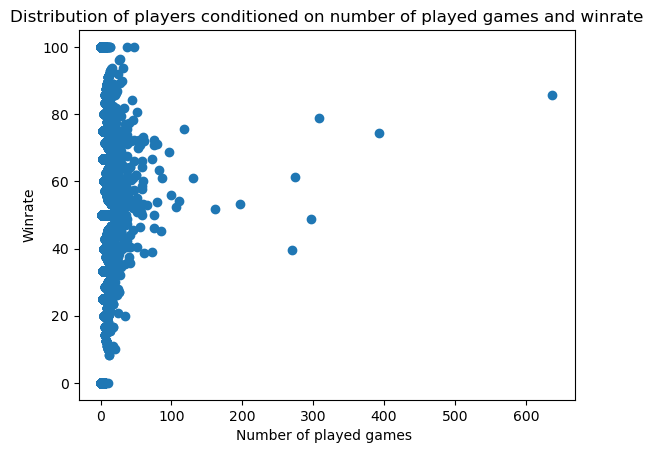

In [117]:
plt.scatter(player_countM, player_percFinish)
plt.xlabel("Number of played games ")
plt.ylabel("Winrate")
plt.title("Distribution of players conditioned on number of played games and winrate")
plt.show()

In [118]:
player_percFinish.loc[player_countM[player_countM == 637].index]

hashIP
473d6ac602c2b198    85.5573
dtype: float64

There is an outlier in the number of played games: one player played 637 games.  Let's look at the previous graph by ignoring this outlier and other possible outliers.

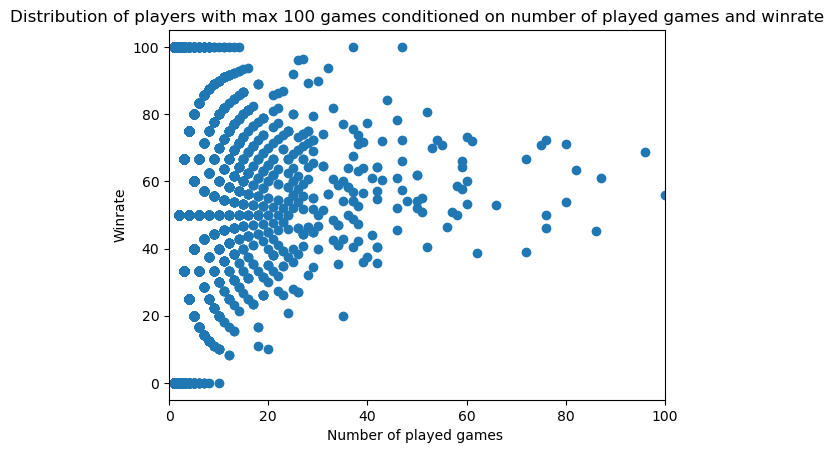

In [119]:
plt.scatter(player_countM, player_percFinish)
plt.xlim(0, 100) # looking only at players with max 100 played games
plt.xlabel("Number of played games ")
plt.ylabel("Winrate")
plt.title("Distribution of players with max 100 games conditioned on number of played games and winrate")
plt.show()

In [120]:
player_countM.corr(player_percFinish) # looking at all players

0.12358873466026771

In [121]:
player_countM[player_countM <= 100].corr(player_percFinish[player_countM <= 100]) # looking at players that played less than 100 or 100 games

0.19482991378619793

Even when looking at only players with fewer games, it is hard to see a direct larger correlation between the number of played games and the winrate. Let's see if the distribution of finished VS unfinished games varies a lot between players.

### Distribution of winrates of players

In [122]:
player_percFinish.describe()

count    13765.000000
mean        34.554632
std         38.415080
min          0.000000
25%          0.000000
50%         25.000000
75%         66.666667
max        100.000000
dtype: float64

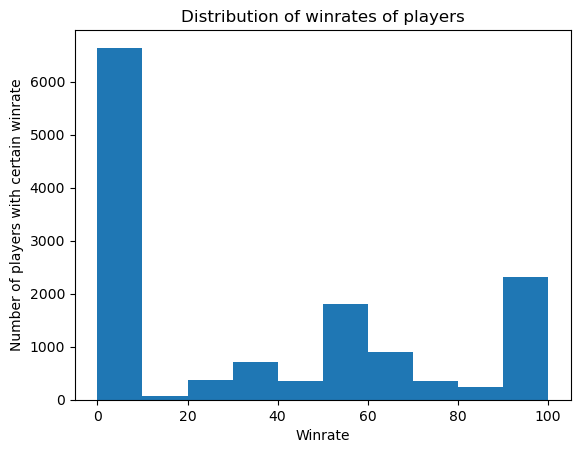

In [123]:
plt.hist(player_percFinish)
plt.xlabel("Winrate")
plt.ylabel("Number of players with certain winrate")
plt.title("Distribution of winrates of players")
plt.show()

In [124]:
print(100 * player_percFinish[player_percFinish == 0].count()/player_percFinish.count(), "% of players have a winrate of 0%, ", 100 * player_percFinish[player_percFinish == 100].count()/player_percFinish.count(), "% of players have a winrate of 100%")

48.223755902651654 % of players have a winrate of 0%,  16.563748637849617 % of players have a winrate of 100%


### Analysing given difficulty ratings for missions

Let's now see if there is a correlation between the difficulty given by players for a mission and the percentage of games of this missions where people did not succeed. First, we will check how many missions are present in both finished and unfinished paths 

In [125]:
games.head()

,difficulty_rating,duration,finished,hashIP,num_backward,path,path_length,source_article,target_article,timestamp,type_end,newhashIP
0,NaN,166,True,6a3701d319fc3754,0,"[14th_century, 15th_century, 16th_century, Pac...",9,14th_century,African_slave_trade,2011-02-15 03:26:49,NaN,6a3701d319fc3754_0
1,3.0,88,True,3824310e536af032,0,"[14th_century, Europe, Africa, Atlantic_slave_...",5,14th_century,African_slave_trade,2012-08-12 06:36:52,NaN,3824310e536af032_0
2,NaN,138,True,415612e93584d30e,0,"[14th_century, Niger, Nigeria, British_Empire,...",8,14th_century,African_slave_trade,2012-10-03 21:10:40,NaN,415612e93584d30e_0
3,3.0,175,True,015245d773376aab,0,"[14th_century, Italy, Roman_Catholic_Church, H...",7,14th_century,John_F._Kennedy,2013-04-23 15:27:08,NaN,015245d773376aab_0
4,NaN,110,True,5295bca242be81fe,0,"[14th_century, Europe, North_America, United_S...",6,14th_century,John_F._Kennedy,2013-07-03 22:26:54,NaN,5295bca242be81fe_0


In [126]:
counts_per_mission = games[['source_article', 'target_article', 'finished']].drop_duplicates().groupby(['source_article', 'target_article']).count()
counts_per_mission.head()
missions_both = counts_per_mission[counts_per_mission['finished'] == 2].reset_index(level=['source_article', 'target_article'])[['source_article', 'target_article']]
missions_both.head() # dataframe containing missions that are both in finished and unfinished paths

,source_article,target_article
0,11th_century,Plum
1,13th_century,Bison
2,14th_century,African_slave_trade
3,14th_century,Elizabeth_I_of_England
4,14th_century,Rainbow


In [127]:
100*missions_both.shape[0] / games[['source_article', 'target_article']].drop_duplicates().shape[0]

8.05398345668263

Only 8% of possible missions were at least won once and at least lost once by someone. For all these missions, let's collect the number of times they were won, the number of times they were lost, the number of available difficulty ratings and the average difficulty rating (if any).

In [128]:
games_both = games.merge(missions_both, on = ['source_article', 'target_article'], how='inner')
games_both = games_both.groupby(['source_article', 'target_article']).agg(no_won = ('finished', 'sum'), no_lost = ('finished', lambda a: (a == False).sum()), no_diff = ('difficulty_rating', 'count'), avg_diff = ('difficulty_rating', 'mean'))
games_both.head() # dataframe containing information about games that were won and lost at least once

no_won  no_lost  no_diff  avg_diff
source_article target_article                                            
11th_century   Plum                         1        1        1     1.000
13th_century   Bison                        1        2        1     1.000
14th_century   African_slave_trade          3        4        1     3.000
               Elizabeth_I_of_England       4        3        2     2.500
               Rainbow                     18       23        8     2.375

In [129]:
100*games_both.query("no_diff == 0").shape[0] / games_both.shape[0]

43.99168399168399

In [130]:
100*games.groupby(['source_article', 'target_article']).count().query("difficulty_rating == 0").shape[0] / games.groupby(['source_article', 'target_article']).count().shape[0] 

73.87562372325107

Out of all games that were at least won and lost once, only 44% have 0 difficulty ratings, which is way lower than when we took into account all played missions, where almost 73% of missions had no difficulty rating.

In [131]:
games_both.describe()

,no_won,no_lost,no_diff,avg_diff
count,2405.000000,2405.000000,2405.000000,1347.000000
mean,3.950936,3.434511,1.465696,2.556597
std,38.042888,36.481453,14.581066,1.117635
min,1.000000,1.000000,0.000000,1.000000
25%,1.000000,1.000000,0.000000,2.000000
50%,1.000000,1.000000,1.000000,2.500000
75%,2.000000,2.000000,1.000000,3.000000
max,1041.000000,1004.000000,403.000000,5.000000


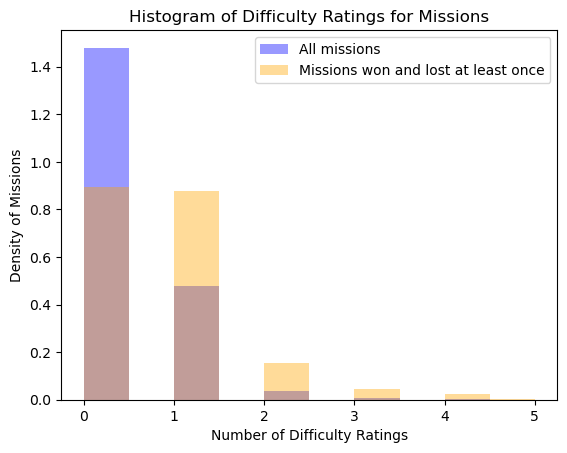

In [132]:
# distribution of count of difficulty ratings per mission in dataframe of all games
games_diff = games.groupby(['source_article', 'target_article']).count()['difficulty_rating'] 

# distribution of count of difficulty ratings per mission in dataframe of games that were at least won and lost once
games_both_diff = games_both['no_diff']

plt.hist(games_diff, range=(0, 5), alpha=0.4, color='blue', label='All missions', density = True)
plt.hist(games_both_diff, range=(0, 5), alpha=0.4, color='orange', label='Missions won and lost at least once', density = True)

plt.xlabel("Number of Difficulty Ratings")
plt.ylabel("Density of Missions")
plt.title("Histogram of Difficulty Ratings for Missions")
plt.legend()

plt.show()

We can see how when looking at games that were at least won and lost once, the distribution of the number of difficulty ratings is more diverse than in the case where we are looking at all the missions, where most of the missions had no difficulty rating.

#### Correlation between average difficulty of a mission (given by players) and winrate of that mission

We can now finally check if there is a correlation between the average difficulty rating and the number of times a game was lost for games that were lost and won at least once.

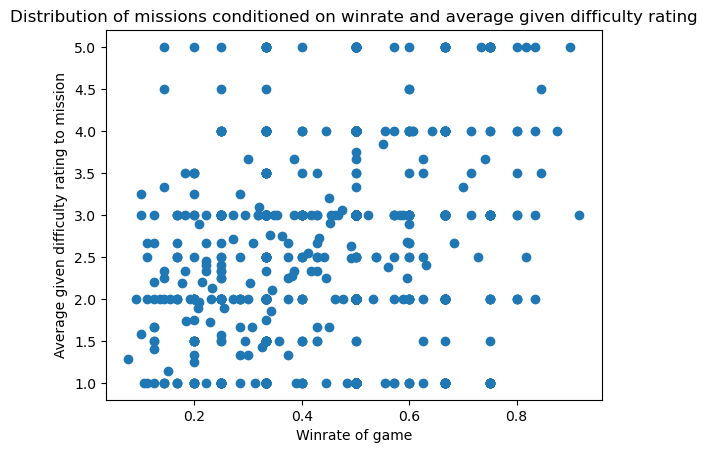

In [133]:
one_diff = games_both[games_both['no_diff'] != 0] # look at games that have at least one difficulty rating
perc_lost = one_diff.apply(lambda a: a.no_lost / (a.no_won + a.no_lost), axis = 1) # calculate percentage of lost games
plt.xlabel("Winrate of game")
plt.ylabel("Average given difficulty rating to mission")
plt.title("Distribution of missions conditioned on winrate and average given difficulty rating")
plt.scatter(perc_lost, one_diff['avg_diff'])
plt.show()

In [134]:
perc_lost.corr(one_diff['avg_diff'])

0.18082218434778327

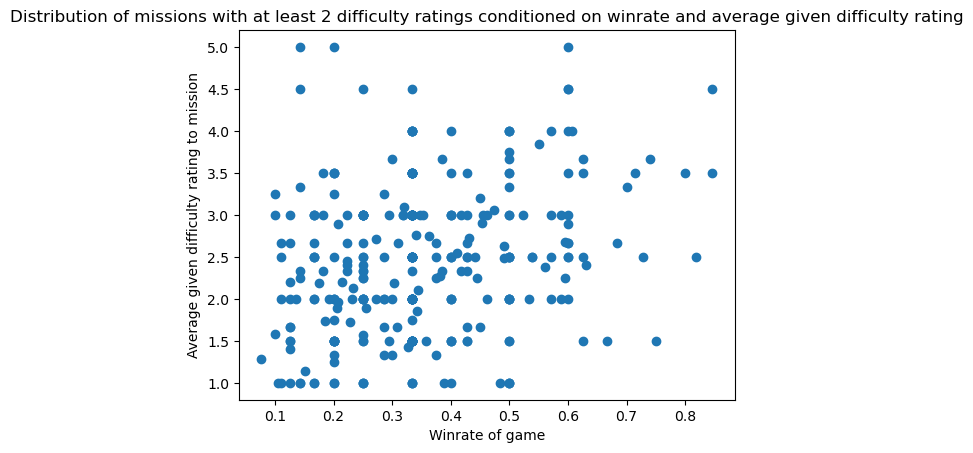

In [135]:
one_diff = games_both[games_both['no_diff'] > 1] # look at games that have at least two difficulty rating
perc_lost = one_diff.apply(lambda a: a.no_lost / (a.no_won + a.no_lost), axis = 1) # calculate percentage of lost games
plt.scatter(perc_lost, one_diff['avg_diff'])
plt.xlabel("Winrate of game")
plt.ylabel("Average given difficulty rating to mission")
plt.title("Distribution of missions with at least 2 difficulty ratings conditioned on winrate and average given difficulty rating")
plt.show()

In [136]:
perc_lost.corr(one_diff['avg_diff'])

0.26961009039563694

We can see the correlation score is bigger if we take into account only the missions for which we have more difficulty ratings.

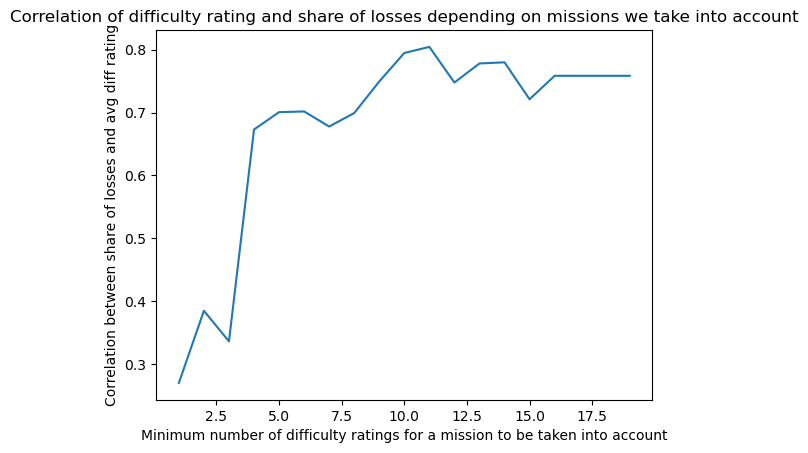

In [137]:
x = range(1, 20)
corr = []
for i in x:
    one_diff = games_both[games_both['no_diff'] > i] # look at games that have at least i difficulty rating
    perc_lost = one_diff.apply(lambda a: a.no_lost / (a.no_won + a.no_lost), axis = 1) # calculate percentage of lost games
    corr.append(perc_lost.corr(one_diff['avg_diff']))
plt.plot(x, corr)
plt.xlabel("Minimum number of difficulty ratings for a mission to be taken into account")
plt.ylabel("Correlation between share of losses and avg diff rating")
plt.title("Correlation of difficulty rating and share of losses depending on missions we take into account")
plt.show()

#### Correlation between given difficulty rating and player that played

Until now, we haven't taken into account the player that plays a certain mission. We will now analyse how much does the difficulty rating depend on the player by checking if different players give different difficulty ratings even if they both lost / won the same amount of missions / the same missions. This can help us detect player bias - if some players consistently give higher or lower ratings.

In [138]:
# creating a dataframe where for each player we have number of wins, losses, number of given diff rating and avg difficulty rating
player_stat = games.groupby('hashIP').agg(no_won = ('finished', 'sum'), no_lost = ('finished', lambda a: (a == False).sum()), no_rating = ('difficulty_rating', 'count'), avg_rating = ('difficulty_rating', 'mean'))
player_stat.head()

,no_won,no_lost,no_rating,avg_rating
hashIP,,,,
000386124f307de8,1,1,1,1.0
0007183207b6008f,3,0,1,1.0
000a5bac5b7781ea,1,0,0,NaN
000a6e585b776c96,0,1,0,NaN
000d397013f09039,2,0,2,2.0


In [139]:
100*player_stat[player_stat['no_rating'] > 0].shape[0] / player_stat.shape[0]

30.708318198329096

Only 30.7% of players gave at least one difficulty rating. FIrst, let's see if we can find something in common for all players that did not give any ranking. Is their distribution of % of won games very different than for players that did give ratings?

In [140]:
perc_distr_noRank = player_stat[player_stat['no_rating'] == 0].apply(lambda a: a.no_won / (a.no_won + a.no_lost), axis = 1)
perc_distr_noRank.head() # winrate for players that did not give any ranking

perc_distr_Rank = player_stat[player_stat['no_rating'] > 0].apply(lambda a: a.no_won / (a.no_won + a.no_lost), axis = 1)
perc_distr_Rank.head() # winrate for players that gave at least one rating

hashIP
000386124f307de8    0.50
0007183207b6008f    1.00
000d397013f09039    1.00
000e5d4c2c8e921f    0.25
001a0e3b756ed203    1.00
dtype: float64

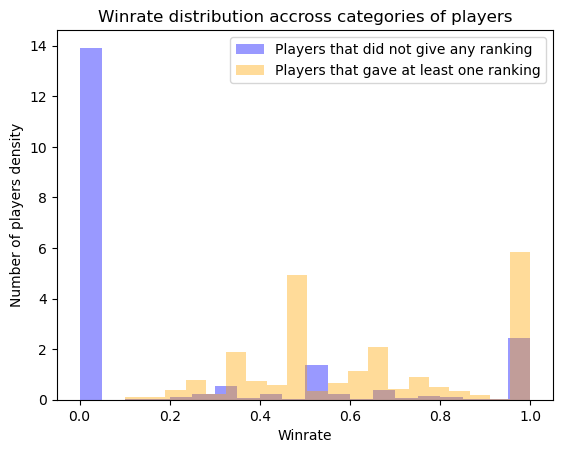

In [141]:
# distribution of winrate accross players
plt.hist(perc_distr_noRank, alpha=0.4, color='blue', bins = 20, label='Players that did not give any ranking', density = True)
plt.hist(perc_distr_Rank, alpha=0.4, color='orange', bins = 20, label='Players that gave at least one ranking', density = True)

plt.xlabel("Winrate")
plt.ylabel("Number of players density")
plt.title("Winrate distribution accross categories of players")
plt.legend()

plt.show()

In [142]:
perc_distr_Rank.describe()

count    4227.000000
mean        0.647344
std         0.253964
min         0.100000
25%         0.500000
50%         0.600000
75%         1.000000
max         1.000000
dtype: float64

In [143]:
perc_distr_noRank[perc_distr_noRank == 0].size / perc_distr_noRank.size # how many have winrate 0 that did not give rating

0.6959530299853218

In [144]:
perc_distr_noRank[perc_distr_noRank == 1].size / perc_distr_noRank.size # how many have winrate 1 that did not give rating

0.12277206961627175

In [145]:
perc_distr_Rank[perc_distr_Rank == 1].size / perc_distr_Rank.size # how many have winrate 1 that did give rating

0.26236101253844335

For players that did not give any rating, 69% of them failed all their missions, 12% succeeded all missions, and the rest have a winrate that is between 0 or 1. Players that gave at least one ranking have a winrate of 1 in 26% of cases, but also have a winrate between 0 and 1 more often than players that did not give any ratings. From all players that gave at least one ranking, no one had a winrate of 0.

We will now focus on players that gave ratings and see if the given average rating depends on the winrate (and so, is very similar for players with same winrates) or if it is player dependent (some players tend to give higher / lower ratings).

In [146]:
player_with_rating = player_stat[player_stat['no_rating'] > 0] # information about players that gave at least one rating
player_with_rating.head()

,no_won,no_lost,no_rating,avg_rating
hashIP,,,,
000386124f307de8,1,1,1,1.0
0007183207b6008f,3,0,1,1.0
000d397013f09039,2,0,2,2.0
000e5d4c2c8e921f,1,3,1,3.0
001a0e3b756ed203,2,0,2,2.0


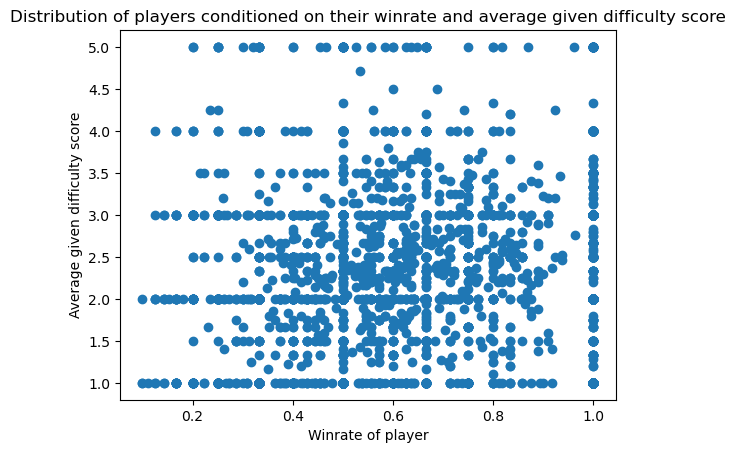

In [147]:
plt.scatter(perc_distr_Rank, player_with_rating['avg_rating']) # showing relationship between winrate and average rating
plt.xlabel("Winrate of player")
plt.ylabel("Average given difficulty score")
plt.title("Distribution of players conditioned on their winrate and average given difficulty score")
plt.show()

In [148]:
player_with_rating.loc[:, 'winrate'] = player_with_rating['no_won'] / (player_with_rating['no_won'] + player_with_rating['no_lost'])

C:\Users\bgabe\AppData\Local\Temp\ipykernel_22480\1141648315.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  player_with_rating.loc[:, 'winrate'] = player_with_rating['no_won'] / (player_with_rating['no_won'] + player_with_rating['no_lost'])


C:\Users\bgabe\AppData\Local\Temp\ipykernel_22480\536374785.py:5: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  std_devs = player_with_bins.groupby('winrate_bin')['avg_rating'].std()
C:\Users\bgabe\AppData\Local\Temp\ipykernel_22480\536374785.py:6: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  counts = player_with_bins.groupby('winrate_bin')['avg_rating'].count()


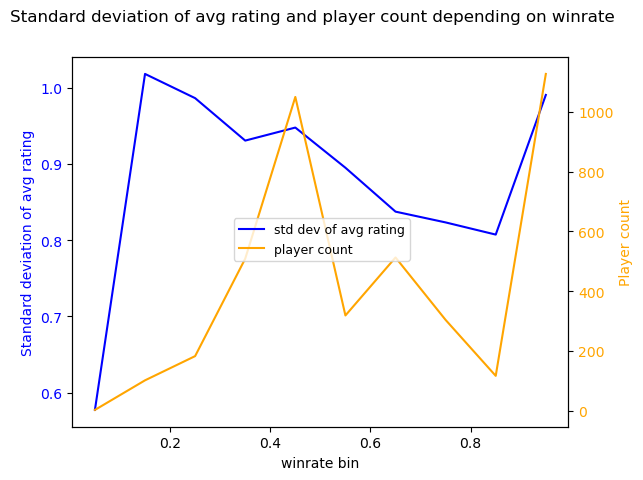

In [149]:
x = np.linspace(0, 1, 11)
player_with_bins = player_with_rating.copy()
player_with_bins['winrate_bin'] = pd.cut(player_with_rating['winrate'], bins=x)

std_devs = player_with_bins.groupby('winrate_bin')['avg_rating'].std()
counts = player_with_bins.groupby('winrate_bin')['avg_rating'].count()

x = std_devs.index.categories.mid
y_std = std_devs.values
y_count = counts.values

fig, axes = plt.subplots()

axes.plot(x, y_std, color='blue', label='std dev of avg rating')
axes.set_xlabel("winrate bin")
axes.set_ylabel("Standard deviation of avg rating", color='blue')
axes.tick_params(axis='y', labelcolor='blue')

axes2 = axes.twinx()
axes2.plot(x, y_count, color='orange', label='player count')
axes2.set_ylabel("Player count", color='orange')
axes2.tick_params(axis='y', labelcolor='orange')

fig.suptitle("Standard deviation of avg rating and player count depending on winrate")
fig.legend(loc="center", fontsize = 9)
plt.show()


We can see standard deviation of average rating stays high even when we compare players of same winrate, which means that the average rating depends a lot on the characteristics of a player, and not only on their winrate. F.e. a player may always give higher/lower ratings.

In [150]:
player_with_rating[player_with_rating['winrate'] == 1].head()

,no_won,no_lost,no_rating,avg_rating,winrate
hashIP,,,,,
0007183207b6008f,3,0,1,1.000000,1.0
000d397013f09039,2,0,2,2.000000,1.0
001a0e3b756ed203,2,0,2,2.000000,1.0
003e2ff46b3b4815,2,0,1,1.000000,1.0
00584a976bfaab68,7,0,7,3.428571,1.0


In [151]:
perc_distr_Rank.corr( player_with_rating['avg_rating']) # correlation factor between winrate and difficulty rating

0.04828519013859604

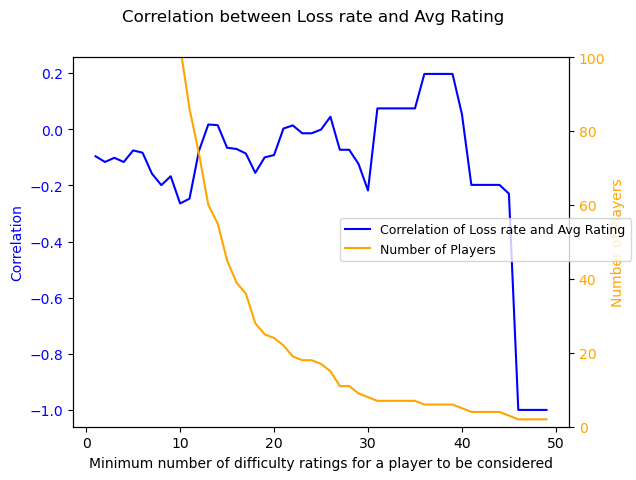

In [152]:
x = range(1, 50)
corr = []
num_players = []

for i in x:
    one_rat = player_with_rating[player_with_rating['no_rating'] > i] # players with at least i given rankings
    perc_lost = one_rat.apply(lambda a: a.no_lost / (a.no_won + a.no_lost), axis=1) # winrate for them
    corr.append(perc_lost.corr(one_rat['avg_rating'])) # append correlation
    num_players.append(len(one_rat)) # append number of players

fig, axes = plt.subplots()

axes.plot(x, corr, color='blue', label='Correlation of Loss rate and Avg Rating')
axes.set_xlabel("Minimum number of difficulty ratings for a player to be considered")
axes.set_ylabel("Correlation", color='blue')
axes.tick_params(axis='y', labelcolor='blue')

axes2 = axes.twinx()
axes2.plot(x, num_players, color='orange', label='Number of Players')
axes2.set_ylabel("Number of Players", color='orange')
axes2.set_ylim(0, 100)
axes2.tick_params(axis='y', labelcolor='orange')

fig.suptitle("Correlation between Loss rate and Avg Rating")
fig.legend(loc="center right", fontsize = 9)
plt.show()


The correlation between the winrate and average rating a player gave is negative in most cases which is expected since players that play more will more likely have higher winrates (samller loss rates). We can see that the absolute correlation between the winrate and avg rating of a player increases when we take into account only players that gave more ratings, but this reduces the number of players from which we can take the data. 

### Change of shortest path in first 3 clicks

We noticed that in some unfinished games, the target article name does not exist in the list of all articles, f.e. "Podcast" or "Long_peper" (only "Podcasting" and "Long_pepper" articles exist), so we remove those games.

In [153]:
games = games[games['target_article'].isin(articles_df['article_name'])]

In [154]:
games_first3 = games[['source_article', 'target_article', 'path']]
games_first3 = games_first3[games_first3['path'].apply(len) > 4]

In [155]:
games_first3['first_click'] = games_first3.apply(lambda a: a.path[1], axis = 1)
games_first3['second_click'] = games_first3.apply(lambda a: a.path[2], axis = 1)
games_first3['third_click'] = games_first3.apply(lambda a: a.path[3], axis = 1)

In [156]:
games_first3.head()

,source_article,target_article,path,first_click,second_click,third_click
0,14th_century,African_slave_trade,"[14th_century, 15th_century, 16th_century, Pac...",15th_century,16th_century,Pacific_Ocean
1,14th_century,African_slave_trade,"[14th_century, Europe, Africa, Atlantic_slave_...",Europe,Africa,Atlantic_slave_trade
2,14th_century,African_slave_trade,"[14th_century, Niger, Nigeria, British_Empire,...",Niger,Nigeria,British_Empire
3,14th_century,John_F._Kennedy,"[14th_century, Italy, Roman_Catholic_Church, H...",Italy,Roman_Catholic_Church,HIV
4,14th_century,John_F._Kennedy,"[14th_century, Europe, North_America, United_S...",Europe,North_America,United_States


In [157]:
def get_sp(row, i): # get length of shortest path between article number i in game path and target of game
    article_name = row.path[i]
    while(article_name == "<"):
        i = i-1
        article_name = row.path[i]
    source_article = article_name
    target_article = row['target_article']
    return distance_df.loc[source_article, target_article]

games_first3['initial_sp'] = games_first3.apply(lambda a: get_sp(a, 0), axis=1)
games_first3['first_sp'] = games_first3.apply(lambda a: get_sp(a, 1), axis=1)
games_first3['second_sp'] = games_first3.apply(lambda a: get_sp(a, 2), axis=1)
games_first3['third_sp'] = games_first3.apply(lambda a: get_sp(a, 3), axis=1)

In [158]:
games_first3.head()

,source_article,target_article,path,first_click,second_click,third_click,initial_sp,first_sp,second_sp,third_sp
0,14th_century,African_slave_trade,"[14th_century, 15th_century, 16th_century, Pac...",15th_century,16th_century,Pacific_Ocean,3.0,3.0,3.0,3.0
1,14th_century,African_slave_trade,"[14th_century, Europe, Africa, Atlantic_slave_...",Europe,Africa,Atlantic_slave_trade,3.0,3.0,2.0,1.0
2,14th_century,African_slave_trade,"[14th_century, Niger, Nigeria, British_Empire,...",Niger,Nigeria,British_Empire,3.0,3.0,2.0,3.0
3,14th_century,John_F._Kennedy,"[14th_century, Italy, Roman_Catholic_Church, H...",Italy,Roman_Catholic_Church,HIV,3.0,2.0,2.0,2.0
4,14th_century,John_F._Kennedy,"[14th_century, Europe, North_America, United_S...",Europe,North_America,United_States,3.0,2.0,2.0,1.0


In [159]:
print(f"We observe {games_first3.shape[0]} games")

We observe 28321 games


In [160]:
print(f"In {100*games_first3[(games_first3['initial_sp'] == games_first3['first_sp']) & (games_first3['initial_sp'] == games_first3['second_sp']) & (games_first3['initial_sp'] == games_first3['third_sp'])].shape[0]/games_first3.shape[0]}% games the shortest path does not change in the first 3 clicks.")

In 14.607535044666502% games the shortest path does not change in the first 3 clicks.


In [161]:
print(f"In {100*games_first3[(games_first3['initial_sp'] > games_first3['first_sp']) & (games_first3['first_sp'] > games_first3['second_sp']) & (games_first3['second_sp'] > games_first3['third_sp'])].shape[0]/games_first3.shape[0]}% games the shortest path diminishes for each of the first 3 clicks.")

In 1.998517001518308% games the shortest path diminishes for each of the first 3 clicks.


In [162]:
print(f"In {100*games_first3[(games_first3['initial_sp'] < games_first3['first_sp']) & (games_first3['first_sp'] < games_first3['second_sp']) & (games_first3['second_sp'] < games_first3['third_sp'])].shape[0]/games_first3.shape[0]}% games the shortest path becomes larger for each of the first 3 clicks.")

In 0.0% games the shortest path becomes larger for each of the first 3 clicks.


In [163]:
print(f"In {100*games_first3[(games_first3['initial_sp'] == games_first3['third_sp'])].shape[0]/games_first3.shape[0]}% games the shortest path is the same at the beginning and after the third click.")

In 29.698810070265882% games the shortest path is the same at the beginning and after the third click.


In [164]:
print(f"In {100*games_first3[(games_first3['initial_sp'] < games_first3['third_sp'])].shape[0]/games_first3.shape[0]}% games the shortest path is larger after the third click than at the beginning.")

In 3.7145581017619436% games the shortest path is larger after the third click than at the beginning.


In [165]:
print(f"In {100*games_first3[(games_first3['initial_sp'] > games_first3['third_sp'])].shape[0]/games_first3.shape[0]}% games the shortest path is smaller after the third click than at the beginning.")

In 66.54426044278098% games the shortest path is smaller after the third click than at the beginning.


In [166]:
print(f"In {100*games_first3[(games_first3['initial_sp'] - 1 > games_first3['third_sp'])].shape[0]/games_first3.shape[0]}% games the shortest path is smaller by two after the third click than at the beginning.")

In 23.58320680766922% games the shortest path is smaller by two after the third click than at the beginning.


In [167]:
print(f"In {100*games_first3[(games_first3['initial_sp'] - 2 > games_first3['third_sp'])].shape[0]/games_first3.shape[0]}% games the shortest path is followed up to the third click than at the beginning.")

In 1.998517001518308% games the shortest path is followed up to the third click than at the beginning.


# Inherent difficulty

Before analysing games, it is important to consider the inherent difficulty of a given mission (source and target pair). This can be determined by analysing the underlying structure of the Wikispeedia graph. We take into account the following features:
* 

We will train a logistic regression model to see which of these features influences the most the inherent difficulty of a mission. For the target variable of the train set, we choose the information about the win or loss of the game. More precisely, for each played game, we identify the source and target article and first extract the previously listed features from the underlying structure of the graph. The target value for that game is 1 if it was lost or 0 if it was won. The features and target value are then one of the entries in our train set.

To make sure we get meaningful results, we will train our model over games played by "noobs" - players that played at most 4 games. This ensures that their win and loss depends way more on the inherent difficulty of the game, and not on their game knowledge that grows as they play more. 

In [168]:
count_player = games.groupby('newhashIP')[['source_article', 'target_article', 'finished', 'timestamp']].count()
noob_players = count_player[count_player['timestamp'] < 5].index # hashIPs of noob players
noob_games = games.copy()[games['newhashIP'].isin(noob_players)][['source_article', 'target_article', 'finished']]
noob_games['lost'] = noob_games['finished'].apply(lambda a: int(not a))
noob_games.drop(columns = ['finished'], inplace = True)
print(noob_games.shape[0])
noob_games.head()

19316


,source_article,target_article,lost
10,14th_century,Rainbow,0
14,14th_century,Rainbow,0
20,14th_century,Rainbow,0
32,2004_Atlantic_hurricane_season,Ice_age,0
34,2005_Atlantic_hurricane_season,Jazz,0


In [169]:
noob_games.isna().sum()

source_article    0
target_article    0
lost              0
dtype: int64

In [170]:
from src.graph_processing import from_adjacency_matrix_to_list, generate_inverse_index_mapping, load_pair_data_with_multiindex

adj_list = from_adjacency_matrix_to_list(adj_matrix)
index_mapping = generate_inverse_index_mapping(adj_list)
pair_data = load_pair_data_with_multiindex('data/pair_stats.txt', index_mapping)

pair_data.head(10)

shortest_path_length  \
source       target                                                 
10th_century 10th_century                                       0   
             11th_century                                       1   
             12th_century                                       2   
             13th_century                                       2   
             14th_century                                       2   
             15th_Marine_Expeditionary_Unit                     3   
             15th_century                                       2   
             16_Cygni                                           4   
             16_Cygni_Bb                                        5   
             16th_century                                       2   

                                             shortest_path_count  \
source       target                                                
10th_century 10th_century                                      1   
             11th_century                                      1   
             12th_century                                      5   
             13th_century                                      4   
             14th_century                                      4   
             15th_Marine_Expeditionary_Unit                    1   
             15th_century                                      5   
             16_Cygni                                          4   
             16_Cygni_Bb                                       4   
             16th_century                                      4   

                                             max_sp_node_degree  \
source       target                                               
10th_century 10th_century                                     0   
             11th_century                                    26   
             12th_century                                    48   
             13th_century                                    79   
             14th_century                                    53   
             15th_Marine_Expeditionary_Unit                 112   
             15th_century                                    85   
             16_Cygni                                        63   
             16_Cygni_Bb                                     63   
             16th_century                                    85   

                                             max_sp_avg_node_degree  \
source       target                                                   
10th_century 10th_century                                         0   
             11th_century                                        13   
             12th_century                                        24   
             13th_century                                        35   
             14th_century                                        26   
             15th_Marine_Expeditionary_Unit                      45   
             15th_century                                        37   
             16_Cygni                                            39   
             16_Cygni_Bb                                         34   
             16th_century                                        37   

                                             avg_sp_avg_node_degree  \
source       target                                                   
10th_century 10th_century                                         0   
             11th_century                                        13   
             12th_century                                        23   
             13th_century                                        28   
             14th_century                                        22   
             15th_Marine_Expeditionary_Unit                      45   
             15th_century                                        25   
             16_Cygni                                            36   
             16_Cygni_Bb       

In [171]:
pair_data.describe()

,shortest_path_length,shortest_path_count,max_sp_node_degree,max_sp_avg_node_degree,avg_sp_avg_node_degree,one_longer_path_count,max_ol_node_degree,max_ol_avg_node_degree,avg_ol_avg_node_degree,two_longer_path_count,max_tl_node_degree,max_tl_avg_node_degree
count,18592839.0,18592839.0,18592839.0,18592839.0,18592839.0,18592839.0,18592839.0,18592839.0,18592839.0,18592839.0,18592839.0,18592839.0
mean,3.20173,14.799182,178.686091,67.427937,48.415108,251.346205,261.025691,100.72784,30.811595,29.828264,207.701087,81.268286
std,0.817821,28.337408,86.060558,28.146723,18.04822,154.246201,55.010902,22.522381,21.283338,1.999558,66.9624,21.624948
min,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
25%,3.0,2.0,107.0,45.0,36.0,89.0,212.0,88.0,13.0,30.0,167.0,66.0
50%,3.0,5.0,169.0,66.0,47.0,301.0,294.0,102.0,26.0,30.0,186.0,81.0
75%,4.0,15.0,294.0,89.0,58.0,400.0,294.0,116.0,48.0,30.0,294.0,96.0
max,9.0,2172.0,294.0,198.0,183.0,400.0,294.0,198.0,183.0,30.0,294.0,198.0


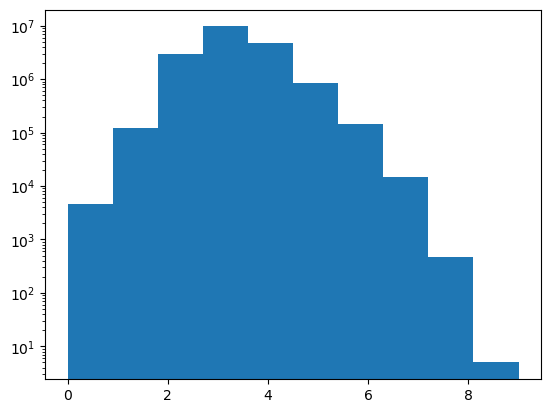

In [172]:
# Plot the shortest path distribution
_ = plt.hist(pair_data['shortest_path_length'], bins=10, log=True)

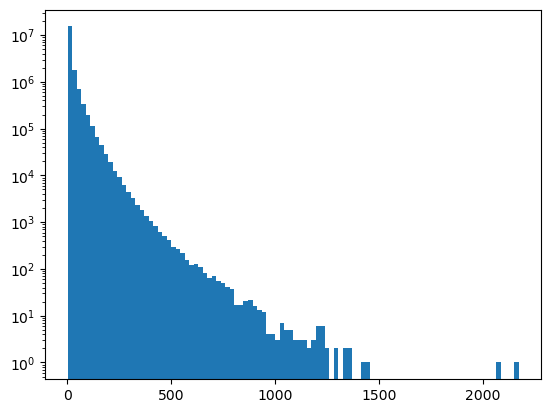

In [173]:
shortest_path_100 = plt.hist(pair_data['shortest_path_count'], bins=100, log=True)

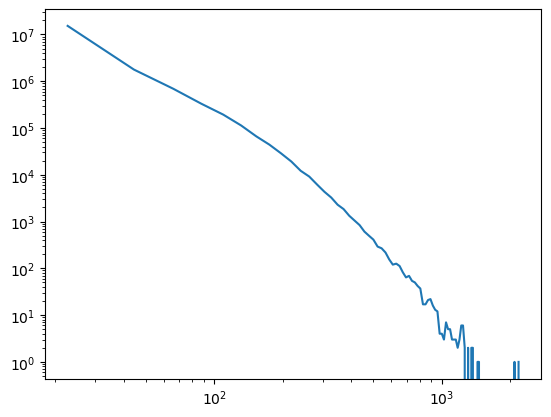

In [174]:
plt.loglog(shortest_path_100[1][1:], shortest_path_100[0])

This does not actually seem to be a proper powerlaw distribution, but it can in principle be approximated as such. As more values are considered it resembles the power law less and less.

Calculating best minimal value for power law fit
Alpha (scaling exponent): 4.664891664300435
Xmin (starting point of power-law behavior): 148.0
Log-likelihood ratio (R): 8.989651631898969
p-value: 0.11873932758828602


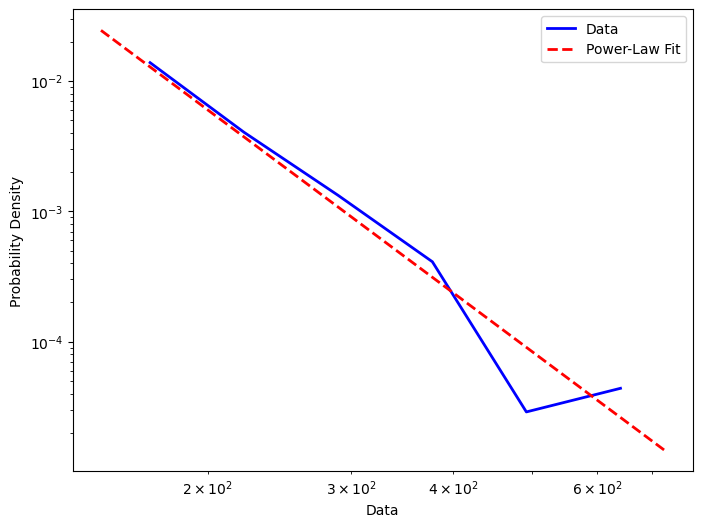

In [175]:
import powerlaw

# Assuming pair_data['shortest_path_count'] is available
data = pair_data['shortest_path_count'].sample(30000)

# Fit the data to a power-law distribution
fit = powerlaw.Fit(data, xmin=None, discrete=True)  # Automatically determine xmin

# Print the alpha value (scaling exponent)
print(f"Alpha (scaling exponent): {fit.alpha}")
print(f"Xmin (starting point of power-law behavior): {fit.xmin}")

# Compare power law vs exponential
R, p = fit.distribution_compare('power_law', 'exponential')
print(f"Log-likelihood ratio (R): {R}")
print(f"p-value: {p}")

# Plot the PDF with the power-law fit
plt.figure(figsize=(8, 6))
fit.plot_pdf(color='blue', linewidth=2)
fit.power_law.plot_pdf(color='red', linestyle='--', linewidth=2)
plt.xlabel("Data")
plt.ylabel("Probability Density")
plt.legend(["Data", "Power-Law Fit"])
plt.show()

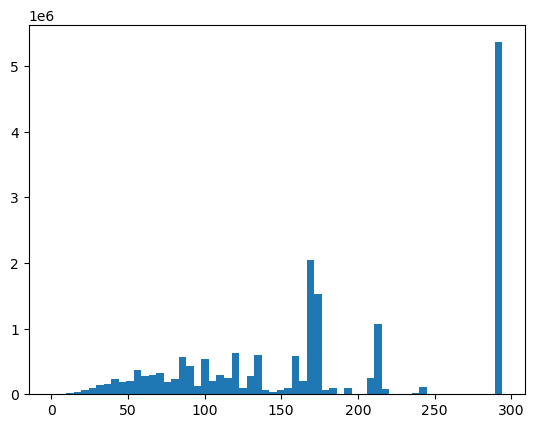

In [176]:
_ = plt.hist(pair_data['max_sp_node_degree'], bins=60, log=False)

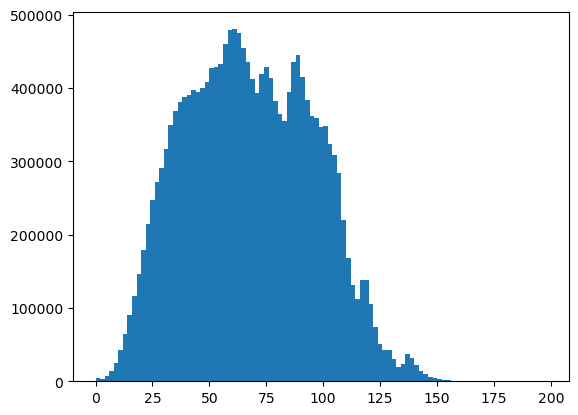

In [177]:
_ = plt.hist(pair_data['max_sp_avg_node_degree'], bins=99, log=False)

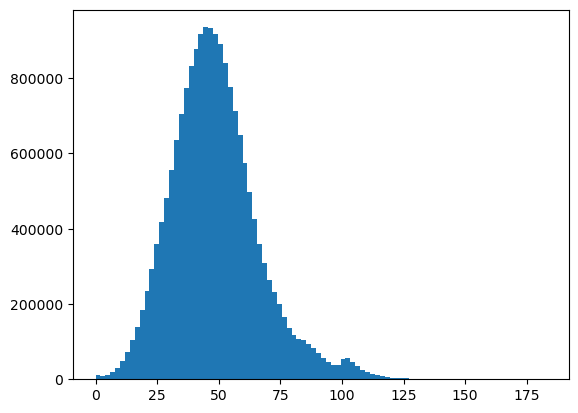

In [178]:
_ = plt.hist(pair_data['avg_sp_avg_node_degree'], bins=92, log=False)

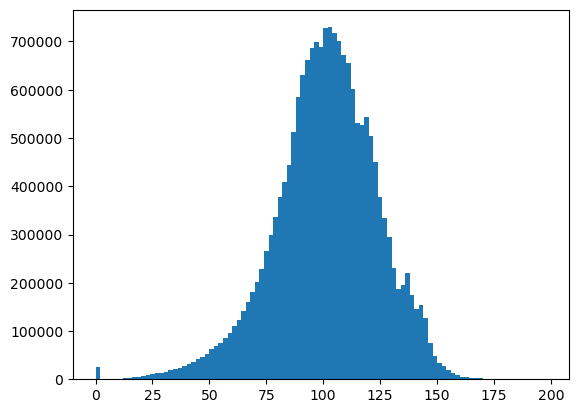

In [179]:
_ = plt.hist(pair_data['max_ol_avg_node_degree'], bins=99, log=False)

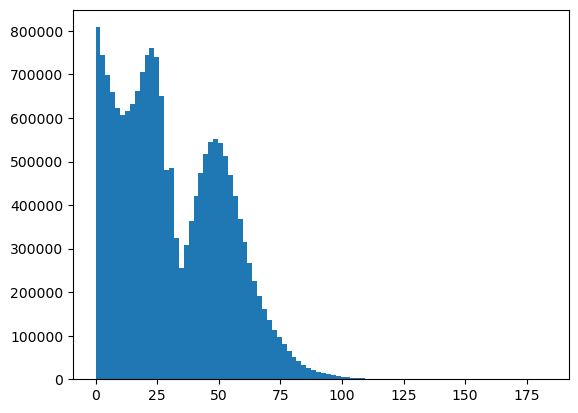

In [180]:
_ = plt.hist(pair_data['avg_ol_avg_node_degree'], bins=92, log=False)

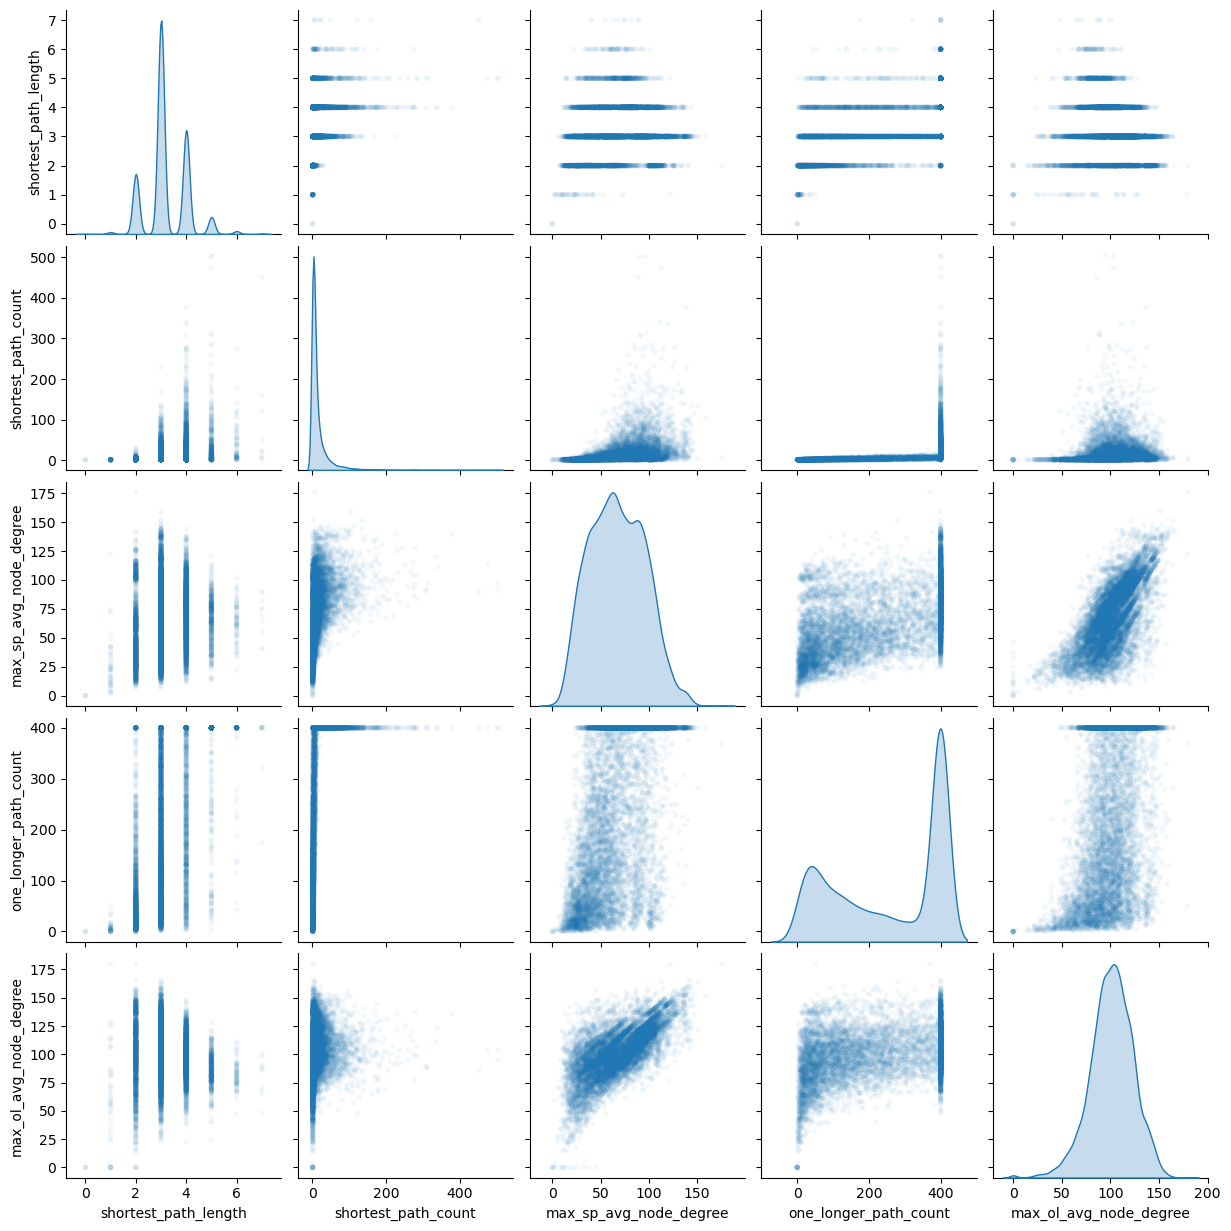

In [181]:
sampled_pair_data = pair_data.sample(10000)
sns.pairplot(sampled_pair_data[
    [
        'shortest_path_length', 
        'shortest_path_count', 
        'max_sp_avg_node_degree', 
        # 'avg_sp_avg_node_degree',
        'one_longer_path_count',
        'max_ol_avg_node_degree',
        # 'avg_ol_avg_node_degree',
    ]
], diag_kind='kde', kind='scatter', plot_kws={'alpha': 0.05, 's': 15, 'edgecolor': 'none'})
plt.show()

In [182]:
pair_data[
    [
        'shortest_path_length', 
        'shortest_path_count', 
        'max_sp_avg_node_degree', 
        'avg_sp_avg_node_degree',
        'one_longer_path_count',
        'max_ol_avg_node_degree',
        'avg_ol_avg_node_degree',
    ]
    # pair_data.columns
].corr(method = 'pearson')

,shortest_path_length,shortest_path_count,max_sp_avg_node_degree,avg_sp_avg_node_degree,one_longer_path_count,max_ol_avg_node_degree,avg_ol_avg_node_degree
shortest_path_length,1.000000,0.356190,0.155182,-0.027637,0.504378,-0.090824,-0.470718
shortest_path_count,0.356190,1.000000,0.387678,0.040417,0.434039,0.107989,-0.356755
max_sp_avg_node_degree,0.155182,0.387678,1.000000,0.780945,0.566561,0.688469,-0.264604
avg_sp_avg_node_degree,-0.027637,0.040417,0.780945,1.000000,0.197050,0.612825,0.090185
one_longer_path_count,0.504378,0.434039,0.566561,0.197050,1.000000,0.406807,-0.761944
max_ol_avg_node_degree,-0.090824,0.107989,0.688469,0.612825,0.406807,1.000000,-0.048329
avg_ol_avg_node_degree,-0.470718,-0.356755,-0.264604,0.090185,-0.761944,-0.048329,1.000000


In [183]:
pair_data.isna().sum()

shortest_path_length      0
shortest_path_count       0
max_sp_node_degree        0
max_sp_avg_node_degree    0
avg_sp_avg_node_degree    0
one_longer_path_count     0
max_ol_node_degree        0
max_ol_avg_node_degree    0
avg_ol_avg_node_degree    0
two_longer_path_count     0
max_tl_node_degree        0
max_tl_avg_node_degree    0
dtype: int64

In [184]:
noob_games = noob_games.set_index(['source_article', 'target_article'])
noob_games.index.names = ['source', 'target']
noob_games.head()

lost
source                         target       
14th_century                   Rainbow     0
                               Rainbow     0
                               Rainbow     0
2004_Atlantic_hurricane_season Ice_age     0
2005_Atlantic_hurricane_season Jazz        0

In [185]:
embeddings_df = pd.read_csv('data/article_embeddings.csv')

embeddings_df['article_name'] = embeddings_df['article_name'].apply(unquote)
embeddings_df.index = embeddings_df['article_name']
embeddings_df.drop(columns=['article_name'], inplace=True)
embeddings_df.sort_index(inplace=True)

# Turn the embedded value into numpy array
embeddings_df['embedding'] = embeddings_df['embedding'].apply(lambda x: np.asarray(x.replace('[', '').replace(']', '').split(', '), dtype=np.float32))
embeddings_df.head(10)

,embedding
article_name,
10th_century,"[-0.78780615, -0.14641005, -1.4445026, -0.3847..."
11th_century,"[-1.2436125, 0.18257824, -1.3233681, -0.616172..."
12th_century,"[-0.92367095, 0.1344378, -0.7907336, -0.424692..."
13th_century,"[-0.9089444, -0.15343712, -0.4361021, 0.125530..."
14th_century,"[-0.11887497, -0.11473719, 0.10210174, 0.41198..."
15th_Marine_Expeditionary_Unit,"[0.14179221, 0.22309469, -0.65339345, 1.159785..."
15th_century,"[-0.28997985, 0.6272335, -0.5373949, 0.2850136..."
16_Cygni,"[0.50224555, 0.41986653, -0.25096476, -0.61669..."
16_Cygni_Bb,"[0.11247331, 0.6774261, -0.45466617, -0.235556..."


## Logistic regression

In [186]:
useful_pair_data = pair_data[
    [
        'shortest_path_length', 
        'shortest_path_count', 
        'one_longer_path_count', 
        'avg_sp_avg_node_degree',
        'max_ol_node_degree',
        # 'avg_ol_avg_node_degree',
        #  'max_sp_avg_node_degree',
    ]
    # pair_data.columns
]

X = noob_games.join(useful_pair_data)
X = X.astype(float)
X.head()

lost  shortest_path_length  \
source                         target                                
14th_century                   Rainbow   0.0                   3.0   
                               Rainbow   0.0                   3.0   
                               Rainbow   0.0                   3.0   
2004_Atlantic_hurricane_season Ice_age   0.0                   3.0   
2005_Atlantic_hurricane_season Jazz      0.0                   2.0   

                                        shortest_path_count  \
source                         target                         
14th_century                   Rainbow                  5.0   
                               Rainbow                  5.0   
                               Rainbow                  5.0   
2004_Atlantic_hurricane_season Ice_age                 58.0   
2005_Atlantic_hurricane_season Jazz                     1.0   

                                        one_longer_path_count  \
source                         target                           
14th_century                   Rainbow                  198.0   
                               Rainbow                  198.0   
                               Rainbow                  198.0   
2004_Atlantic_hurricane_season Ice_age                  400.0   
2005_Atlantic_hurricane_season Jazz                     113.0   

                                        avg_sp_avg_node_degree  \
source                         target                            
14th_century                   Rainbow                    34.0   
                               Rainbow                    34.0   
                               Rainbow                    34.0   
2004_Atlantic_hurricane_season Ice_age                    53.0   
2005_Atlantic_hurricane_season Jazz                      116.0   

                                        max_ol_node_degree  
source                         target                       
14th_century                   Rainbow               172.0  
                               Rainbow               172.0  
                               Rainbow               172.0  
2004_Atlantic_hurricane_season Ice_age               294.0  
2005_Atlantic_hurricane_season Jazz                  294.0

In [187]:
# Add embedding information to the dataset for source and target articles
X = X.join(embeddings_df, on='source')
X.rename(columns={'embedding': 'source_embedding'}, inplace=True)
X = X.join(embeddings_df, on='target')
X.rename(columns={'embedding': 'target_embedding'}, inplace=True)

# Calculate the cosine similarity between the source and target article embeddings and drop the embeddings
X['cosine_similarity'] = X.apply(lambda x: np.dot(x['source_embedding'], x['target_embedding']) / (np.linalg.norm(x['source_embedding']) * np.linalg.norm(x['target_embedding'])), axis=1)
X.drop(columns=['source_embedding', 'target_embedding'], inplace=True)

X.head()

lost  shortest_path_length  \
source                         target                                
14th_century                   Rainbow   0.0                   3.0   
                               Rainbow   0.0                   3.0   
                               Rainbow   0.0                   3.0   
2004_Atlantic_hurricane_season Ice_age   0.0                   3.0   
2005_Atlantic_hurricane_season Jazz      0.0                   2.0   

                                        shortest_path_count  \
source                         target                         
14th_century                   Rainbow                  5.0   
                               Rainbow                  5.0   
                               Rainbow                  5.0   
2004_Atlantic_hurricane_season Ice_age                 58.0   
2005_Atlantic_hurricane_season Jazz                     1.0   

                                        one_longer_path_count  \
source                         target                           
14th_century                   Rainbow                  198.0   
                               Rainbow                  198.0   
                               Rainbow                  198.0   
2004_Atlantic_hurricane_season Ice_age                  400.0   
2005_Atlantic_hurricane_season Jazz                     113.0   

                                        avg_sp_avg_node_degree  \
source                         target                            
14th_century                   Rainbow                    34.0   
                               Rainbow                    34.0   
                               Rainbow                    34.0   
2004_Atlantic_hurricane_season Ice_age                    53.0   
2005_Atlantic_hurricane_season Jazz                      116.0   

                                        max_ol_node_degree  cosine_similarity  
source                         target                                          
14th_century                   Rainbow               172.0           0.395498  
                               Rainbow               172.0           0.395498  
                               Rainbow               172.0           0.395498  
2004_Atlantic_hurricane_season Ice_age               294.0           0.281696  
2005_Atlantic_hurricane_season Jazz                  294.0           0.462522

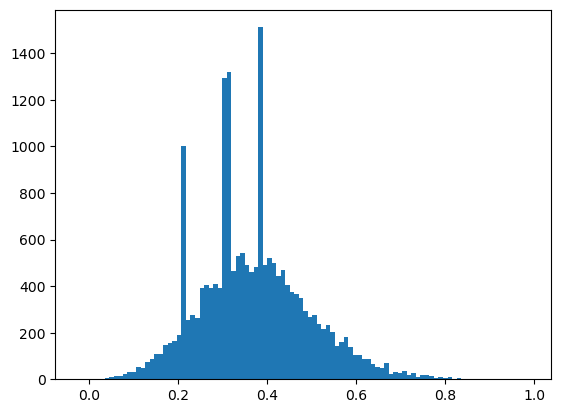

In [188]:
# Get distribution of cosine similarity
_ = plt.hist(X['cosine_similarity'], bins=100)

We also have to drop columns for which we do not have the data (no path exists that connects the two).

In [189]:
X = X.dropna()
X.head()

lost  shortest_path_length  \
source                         target                                
14th_century                   Rainbow   0.0                   3.0   
                               Rainbow   0.0                   3.0   
                               Rainbow   0.0                   3.0   
2004_Atlantic_hurricane_season Ice_age   0.0                   3.0   
2005_Atlantic_hurricane_season Jazz      0.0                   2.0   

                                        shortest_path_count  \
source                         target                         
14th_century                   Rainbow                  5.0   
                               Rainbow                  5.0   
                               Rainbow                  5.0   
2004_Atlantic_hurricane_season Ice_age                 58.0   
2005_Atlantic_hurricane_season Jazz                     1.0   

                                        one_longer_path_count  \
source                         target                           
14th_century                   Rainbow                  198.0   
                               Rainbow                  198.0   
                               Rainbow                  198.0   
2004_Atlantic_hurricane_season Ice_age                  400.0   
2005_Atlantic_hurricane_season Jazz                     113.0   

                                        avg_sp_avg_node_degree  \
source                         target                            
14th_century                   Rainbow                    34.0   
                               Rainbow                    34.0   
                               Rainbow                    34.0   
2004_Atlantic_hurricane_season Ice_age                    53.0   
2005_Atlantic_hurricane_season Jazz                      116.0   

                                        max_ol_node_degree  cosine_similarity  
source                         target                                          
14th_century                   Rainbow               172.0           0.395498  
                               Rainbow               172.0           0.395498  
                               Rainbow               172.0           0.395498  
2004_Atlantic_hurricane_season Ice_age               294.0           0.281696  
2005_Atlantic_hurricane_season Jazz                  294.0           0.462522

In [190]:
print("Class distribution:\n", X['lost'].value_counts())

Class distribution:
 lost
1.0    12473
0.0     6839
Name: count, dtype: int64


### Removing samples from majority class

In [191]:
#X.drop(columns = ['cosine_similarity'], inplace = True)

# Separate the majority and minority classes
majority_class = X[X['lost'] == 1.0]
minority_class = X[X['lost'] == 0.0]

# save original X
X_orig = X.copy()

# Randomly sample from the majority class to match the minority class size
majority_sampled = majority_class.sample(n=len(minority_class), random_state=42)

# Combine the resampled majority class with the original minority class
balanced_data = pd.concat([majority_sampled, minority_class])

# Shuffle the dataset (optional but recommended)
balanced_data = balanced_data.sample(frac=1, random_state=42).reset_index(drop=True)

# Check the new class distribution
print("New class distribution:\n", balanced_data['lost'].value_counts())

X = balanced_data

X.head()

New class distribution:
 lost
0.0    6839
1.0    6839
Name: count, dtype: int64


,lost,shortest_path_length,shortest_path_count,one_longer_path_count,avg_sp_avg_node_degree,max_ol_node_degree,cosine_similarity
0,0.0,3.0,18.0,400.0,34.0,294.0,0.273024
1,1.0,3.0,10.0,380.0,79.0,212.0,0.479255
2,1.0,3.0,4.0,400.0,51.0,294.0,0.318819
3,0.0,3.0,36.0,400.0,69.0,294.0,0.386130
4,1.0,3.0,1.0,45.0,60.0,192.0,0.577608


In [192]:
# X[X['shortest_path_length'].isnull()]

In [193]:
y = X.copy()['lost']
y = y.astype(int)
X.drop(columns = ['lost'], inplace = True)
X.head()

,shortest_path_length,shortest_path_count,one_longer_path_count,avg_sp_avg_node_degree,max_ol_node_degree,cosine_similarity
0,3.0,18.0,400.0,34.0,294.0,0.273024
1,3.0,10.0,380.0,79.0,212.0,0.479255
2,3.0,4.0,400.0,51.0,294.0,0.318819
3,3.0,36.0,400.0,69.0,294.0,0.386130
4,3.0,1.0,45.0,60.0,192.0,0.577608


In [194]:
X_train, X_temp, y_train, y_temp = train_test_split(X, y, train_size = 0.70, random_state = 7, stratify = y)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=7, stratify=y_temp)

# standardization
scaler = StandardScaler()

# train set
X_train = scaler.fit_transform(X_train) # compute z-scores of train set
#X_train = sm.add_constant(X_train) 

# test set
X_test = scaler.transform(X_test) # compute z-scores of test set using same scaler
#X_test = sm.add_constant(X_test)

# validation set
X_val = scaler.transform(X_val) # compute z-scores of test set using same scaler

In [195]:
# Check the new class distribution
print("New class distribution (trainset):\n", y_train.value_counts())
print("New class distribution (validation set):\n", y_val.value_counts())
print("New class distribution (testset):\n", y_test.value_counts())

New class distribution (trainset):
 lost
1    4787
0    4787
Name: count, dtype: int64
New class distribution (validation set):
 lost
1    1026
0    1026
Name: count, dtype: int64
New class distribution (testset):
 lost
0    1026
1    1026
Name: count, dtype: int64


In [196]:
print("Means (first column is intercept):")
print(np.mean(X_train,axis = 0))
print("Standard deviations:")
print(np.std(X_train, axis = 0))

Means (first column is intercept):
[-2.15968181e-16  6.67942827e-18  7.79266631e-18  9.87071066e-17
 -2.50849639e-16 -4.39729028e-17]
Standard deviations:
[1. 1. 1. 1. 1. 1.]


In [197]:
y_train[y_train == 1].count() / y_train.count()

0.5

In [198]:
model = sm.Logit(y_train, X_train).fit()
model.summary()

Optimization terminated successfully.
         Current function value: 0.641216
         Iterations 5


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:                   lost   No. Observations:                 9574
Model:                          Logit   Df Residuals:                     9568
Method:                           MLE   Df Model:                            5
Date:                Tue, 03 Dec 2024   Pseudo R-squ.:                 0.07492
Time:                        10:26:18   Log-Likelihood:                -6139.0
converged:                       True   LL-Null:                       -6636.2
Covariance Type:            nonrobust   LLR p-value:                9.883e-213
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
x1             0.8675      0.030     28.553      0.000       0.808       0.927
x2            -0.1217      0.025     -4.815      0.000      -0.171      -0.072
x3            -0.3212      0.028    -11.339      0.000      -0.377      -0.266
x4             0.1149      0.023      4.962      0.000       0.070       0.160
x5            -0.0989      0.026     -3.875      0.000      -0.149      -0.049
x6             0.0144      0.022      0.646      0.519      -0.029       0.058
==============================================================================
"""

In [199]:
from sklearn.metrics import classification_report

# Verify the model on the test set
y_pred = model.predict(X_test)
y_pred = y_pred > 0.5
print(classification_report(y_test, y_pred, digits=3))

              precision    recall  f1-score   support

           0      0.611     0.668     0.638      1026
           1      0.634     0.575     0.603      1026

    accuracy                          0.621      2052
   macro avg      0.622     0.621     0.621      2052
weighted avg      0.622     0.621     0.621      2052



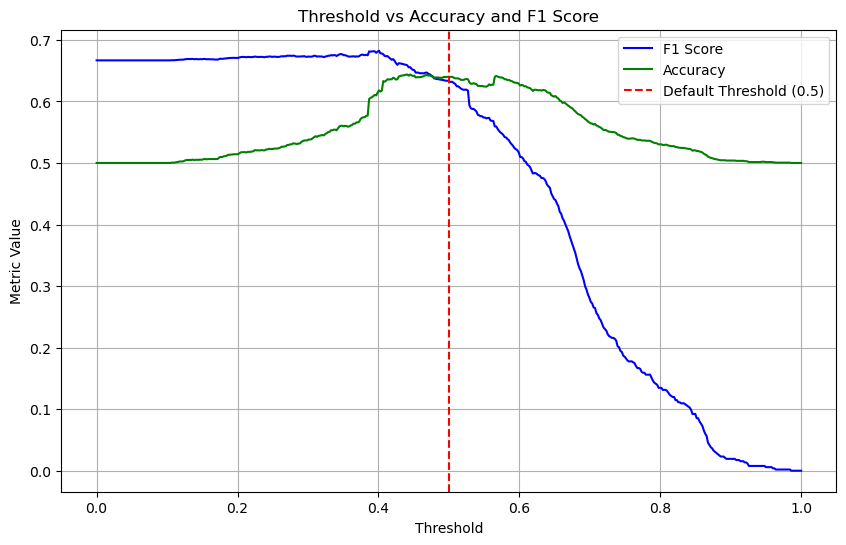

In [200]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import f1_score, accuracy_score

def plot_threshold_vs_metrics(model, X_val, y_val, n=500, start=0.0, end=1.0):
    """
    Plots accuracy and F1-score as a function of the threshold for a statsmodels logistic regression model.

    Args:
        model : Trained statsmodels Logit model
        X_val : Validation features
        y_val : Validation target
        n : Number of thresholds to evaluate
        start : Minimum threshold (default 0.0)
        end : Maximum threshold (default 1.0)
    """
    thresholds = np.linspace(start, end, n)
    f1_scores = []
    accuracies = []

    # Get predicted probabilities
    y_probs = model.predict(X_val)

    for threshold in thresholds:
        # Apply threshold to get predicted labels
        y_pred = (y_probs >= threshold).astype(int)

        # Compute F1-score and accuracy
        f1_scores.append(f1_score(y_val, y_pred))
        accuracies.append(accuracy_score(y_val, y_pred))

    # Plot both metrics
    plt.figure(figsize=(10, 6))
    plt.plot(thresholds, f1_scores, label="F1 Score", color="blue")
    plt.plot(thresholds, accuracies, label="Accuracy", color="green")
    plt.axvline(0.5, color="red", linestyle="--", label="Default Threshold (0.5)")
    plt.xlabel("Threshold")
    plt.ylabel("Metric Value")
    plt.title("Threshold vs Accuracy and F1 Score")
    plt.legend()
    plt.grid(True)
    plt.show()

plot_threshold_vs_metrics(model, X_val, y_val)

In [201]:
# Combine training and validation sets
X_final_train = np.vstack((X_train, X_val))
y_final_train = np.hstack((y_train, y_val))

In [202]:
model = sm.Logit(y_final_train, X_final_train).fit()
model.summary()

Optimization terminated successfully.
         Current function value: 0.640088
         Iterations 5


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:                      y   No. Observations:                11626
Model:                          Logit   Df Residuals:                    11620
Method:                           MLE   Df Model:                            5
Date:                Tue, 03 Dec 2024   Pseudo R-squ.:                 0.07655
Time:                        10:26:20   Log-Likelihood:                -7441.7
converged:                       True   LL-Null:                       -8058.5
Covariance Type:            nonrobust   LLR p-value:                1.445e-264
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
x1             0.8774      0.028     31.867      0.000       0.823       0.931
x2            -0.1339      0.023     -5.872      0.000      -0.179      -0.089
x3            -0.3290      0.026    -12.777      0.000      -0.380      -0.279
x4             0.1217      0.021      5.821      0.000       0.081       0.163
x5            -0.1171      0.023     -5.044      0.000      -0.163      -0.072
x6             0.0200      0.020      0.986      0.324      -0.020       0.060
==============================================================================
"""

In [203]:
# Verify the model on the test set
y_pred = model.predict(X_test)
y_pred = y_pred > 0.49
print(classification_report(y_test, y_pred, digits=3))

              precision    recall  f1-score   support

           0      0.614     0.661     0.636      1026
           1      0.633     0.584     0.607      1026

    accuracy                          0.622      2052
   macro avg      0.623     0.622     0.622      2052
weighted avg      0.623     0.622     0.622      2052



In [204]:
'''
# Extract coefficients
first_idx = 0  
second_idx = 2
coef = [model.params.values[first_idx], model.params.values[second_idx]]

plot_set = X_test.copy()
y_values = y_test.copy()

# Generate grid for contours
xx, yy = np.meshgrid(np.linspace(plot_set[:, first_idx].min() - 0.5, plot_set[:, first_idx].max() + 0.5, 100),
                     np.linspace(plot_set[:, second_idx].min() - 0.5, plot_set[:, second_idx].max() + 0.5, 100))

grid = np.c_[xx.ravel() if first_idx == 0 else np.zeros_like(xx).ravel(),  
             yy.ravel() if second_idx == 1 else np.zeros_like(yy).ravel(),
             yy.ravel() if second_idx == 2 else np.zeros_like(yy).ravel(), 
             yy.ravel() if first_idx == 3 else np.zeros_like(xx).ravel()]

probs = model.predict(grid).reshape(xx.shape)

# Contour plot of probabilities
plt.contourf(xx, yy, probs, levels=50, cmap="RdYlBu", alpha=0.7)
plt.colorbar(label="Probability of Class 1")

# Scatter plot with transparency for better visualization
# go one point at a time to prevent overlapping
plt.scatter(plot_set[y_values == 1, first_idx], plot_set[y_values == 1, second_idx], label="Class 1", color='blue', s=15, alpha=0.2)
plt.scatter(plot_set[y_values == 0, first_idx], plot_set[y_values == 0, second_idx], label="Class 0", color='red', s=15, alpha=0.2)


# # Decision boundary
# x_vals = np.linspace(X_test[:, 0].min(), X_test[:, 0].max(), 100)
# y_vals = -(coef[0] * x_vals + intercept) / coef[1]
# plt.plot(x_vals, y_vals, color='green', label="Decision Boundary")

# Labels, legend, and grid
plt.xlabel("X1 (Feature 1)")
plt.ylabel("X2 (Feature 2)")
plt.title("Logistic Regression Decision Boundary and Data Visualization")
plt.legend()
plt.grid(True)
plt.show()
'''

'\n# Extract coefficients\nfirst_idx = 0  \nsecond_idx = 2\ncoef = [model.params.values[first_idx], model.params.values[second_idx]]\n\nplot_set = X_test.copy()\ny_values = y_test.copy()\n\n# Generate grid for contours\nxx, yy = np.meshgrid(np.linspace(plot_set[:, first_idx].min() - 0.5, plot_set[:, first_idx].max() + 0.5, 100),\n                     np.linspace(plot_set[:, second_idx].min() - 0.5, plot_set[:, second_idx].max() + 0.5, 100))\n\ngrid = np.c_[xx.ravel() if first_idx == 0 else np.zeros_like(xx).ravel(),  \n             yy.ravel() if second_idx == 1 else np.zeros_like(yy).ravel(),\n             yy.ravel() if second_idx == 2 else np.zeros_like(yy).ravel(), \n             yy.ravel() if first_idx == 3 else np.zeros_like(xx).ravel()]\n\nprobs = model.predict(grid).reshape(xx.shape)\n\n# Contour plot of probabilities\nplt.contourf(xx, yy, probs, levels=50, cmap="RdYlBu", alpha=0.7)\nplt.colorbar(label="Probability of Class 1")\n\n# Scatter plot with transparency for better visua

### Oversampling minority class

We lost a lot of data when trying to balance out number of samples for each class. We can remediate to this by balancing them in another way: instead of removing some data entries, we are going to oversample the minority class.

In [205]:
# create X and y
X = X_orig.copy()
y = X.copy()['lost']
y = y.astype(int)
X.drop(columns = ['lost'], inplace = True)
X.head()

X_train, X_temp, y_train, y_temp = train_test_split(X, y, train_size = 0.7, random_state = 7, stratify = y)

# Separate the majority and minority classes based on y_val
majority_class_X = X_temp[y_temp == 1]  # Features for the majority class
majority_class_y = y_temp[y_temp == 1]  # Labels for the majority class

minority_class_X = X_temp[y_temp == 0]  # Features for the minority class
minority_class_y = y_temp[y_temp == 0]  # Labels for the minority class


# Randomly sample from the majority class to match the size of the minority class
majority_sampled_X = majority_class_X.sample(n=len(minority_class_X), random_state=42)
majority_sampled_y = majority_class_y.sample(n=len(minority_class_y), random_state=42)

# Combine the resampled majority class with the original minority class
balanced_X_val = pd.concat([majority_sampled_X, minority_class_X])
balanced_y_val = pd.concat([majority_sampled_y, minority_class_y])

# Shuffle the balanced validation set (optional but recommended)
balanced_X_val, balanced_y_val = balanced_X_val.sample(frac=1, random_state=42), balanced_y_val.sample(frac=1, random_state=42)

X_val, X_test, y_val, y_test = train_test_split(balanced_X_val, balanced_y_val, test_size=0.5, random_state=7, stratify=balanced_y_val)

# standardization
scaler = StandardScaler()

# train set

from imblearn.over_sampling import SMOTE
from sklearn.model_selection import train_test_split

# Apply SMOTE to oversample the minority class
smote = SMOTE(random_state=7, sampling_strategy="not majority")
X_train, y_train = smote.fit_resample(X_train, y_train)

X_train = scaler.fit_transform(X_train) # compute z-scores of train set
#X_train = sm.add_constant(X_train) 

# test set
X_test = scaler.transform(X_test) # compute z-scores of test set using same scaler
#X_test = sm.add_constant(X_test)

X_val = scaler.transform(X_val)

In [206]:
# Check the new class distribution
print("New class distribution (trainset):\n", y_train.value_counts())
print("New class distribution (validation set):\n", y_val.value_counts())
print("New class distribution (testset):\n", y_test.value_counts())

New class distribution (trainset):
 lost
0    8731
1    8731
Name: count, dtype: int64
New class distribution (validation set):
 lost
1    1026
0    1026
Name: count, dtype: int64
New class distribution (testset):
 lost
0    1026
1    1026
Name: count, dtype: int64


In [207]:
model = sm.Logit(y_train, X_train).fit()
model.summary()

Optimization terminated successfully.
         Current function value: 0.631398
         Iterations 5


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:                   lost   No. Observations:                17462
Model:                          Logit   Df Residuals:                    17456
Method:                           MLE   Df Model:                            5
Date:                Tue, 03 Dec 2024   Pseudo R-squ.:                 0.08909
Time:                        10:26:20   Log-Likelihood:                -11025.
converged:                       True   LL-Null:                       -12104.
Covariance Type:            nonrobust   LLR p-value:                     0.000
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
x1             0.9666      0.023     41.399      0.000       0.921       1.012
x2            -0.1591      0.019     -8.333      0.000      -0.197      -0.122
x3            -0.3544      0.021    -16.914      0.000      -0.395      -0.313
x4             0.1430      0.017      8.295      0.000       0.109       0.177
x5            -0.1101      0.019     -5.838      0.000      -0.147      -0.073
x6             0.0020      0.017      0.120      0.905      -0.031       0.035
==============================================================================
"""

In [208]:
from sklearn.metrics import classification_report

# Verify the model on the test set
y_pred = model.predict(X_test)
y_pred = y_pred > 0.5
print(classification_report(y_test, y_pred, digits=3))

              precision    recall  f1-score   support

           0      0.610     0.644     0.627      1026
           1      0.623     0.589     0.606      1026

    accuracy                          0.616      2052
   macro avg      0.617     0.616     0.616      2052
weighted avg      0.617     0.616     0.616      2052



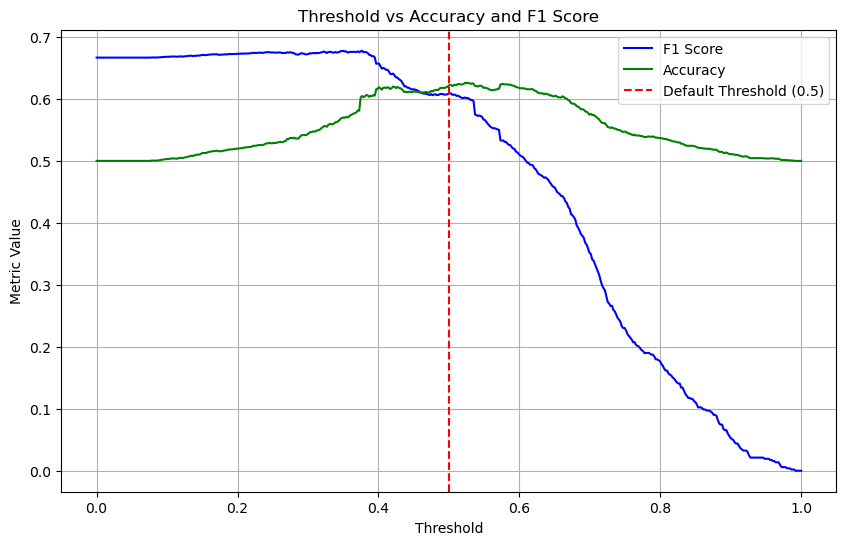

In [209]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import f1_score, accuracy_score

def plot_threshold_vs_metrics(model, X_val, y_val, n=500, start=0.0, end=1.0):
    """
    Plots accuracy and F1-score as a function of the threshold for a statsmodels logistic regression model.

    Args:
        model : Trained statsmodels Logit model
        X_val : Validation features
        y_val : Validation target
        n : Number of thresholds to evaluate
        start : Minimum threshold (default 0.0)
        end : Maximum threshold (default 1.0)
    """
    thresholds = np.linspace(start, end, n)
    f1_scores = []
    accuracies = []

    # Get predicted probabilities
    y_probs = model.predict(X_val)

    for threshold in thresholds:
        # Apply threshold to get predicted labels
        y_pred = (y_probs >= threshold).astype(int)

        # Compute F1-score and accuracy
        f1_scores.append(f1_score(y_val, y_pred))
        accuracies.append(accuracy_score(y_val, y_pred))

    # Plot both metrics
    plt.figure(figsize=(10, 6))
    plt.plot(thresholds, f1_scores, label="F1 Score", color="blue")
    plt.plot(thresholds, accuracies, label="Accuracy", color="green")
    plt.axvline(0.5, color="red", linestyle="--", label="Default Threshold (0.5)")
    plt.xlabel("Threshold")
    plt.ylabel("Metric Value")
    plt.title("Threshold vs Accuracy and F1 Score")
    plt.legend()
    plt.grid(True)
    plt.show()
plot_threshold_vs_metrics(model, X_val, y_val)

In [210]:
# Combine training and validation sets
X_final_train = np.vstack((X_train, X_val))
y_final_train = np.hstack((y_train, y_val))

In [211]:
model = sm.Logit(y_final_train, X_final_train).fit()
model.summary()

Optimization terminated successfully.
         Current function value: 0.633230
         Iterations 5


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:                      y   No. Observations:                19514
Model:                          Logit   Df Residuals:                    19508
Method:                           MLE   Df Model:                            5
Date:                Tue, 03 Dec 2024   Pseudo R-squ.:                 0.08644
Time:                        10:26:22   Log-Likelihood:                -12357.
converged:                       True   LL-Null:                       -13526.
Covariance Type:            nonrobust   LLR p-value:                     0.000
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
x1             0.9438      0.022     43.242      0.000       0.901       0.987
x2            -0.1569      0.018     -8.695      0.000      -0.192      -0.121
x3            -0.3443      0.020    -17.380      0.000      -0.383      -0.305
x4             0.1350      0.016      8.263      0.000       0.103       0.167
x5            -0.1047      0.018     -5.880      0.000      -0.140      -0.070
x6             0.0078      0.016      0.497      0.619      -0.023       0.039
==============================================================================
"""

In [212]:
# Verify the model on the test set
y_pred = model.predict(X_test)
y_pred = y_pred > 0.49
print(classification_report(y_test, y_pred, digits=3))

              precision    recall  f1-score   support

           0      0.612     0.633     0.622      1026
           1      0.620     0.599     0.610      1026

    accuracy                          0.616      2052
   macro avg      0.616     0.616     0.616      2052
weighted avg      0.616     0.616     0.616      2052



In [213]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
cm = confusion_matrix(y_test, y_pred)

print("Confusion Matrix:\n", cm)

Confusion Matrix:
 [[649 377]
 [411 615]]


Resampling does not make our prediction any better. We try another approach: using a non-linear model, such as Decision Tree.

## Decision tree

In [214]:
from sklearn.tree import DecisionTreeClassifier, plot_tree, export_text
# fit the model
model_tree = DecisionTreeClassifier(random_state = 7).fit(X_train, y_train)

In [215]:
# Verify the model on the test set
y_pred = model_tree.predict(X_test)
print(classification_report(y_test, y_pred, digits=3))

              precision    recall  f1-score   support

           0      0.595     0.565     0.580      1026
           1      0.586     0.615     0.600      1026

    accuracy                          0.590      2052
   macro avg      0.590     0.590     0.590      2052
weighted avg      0.590     0.590     0.590      2052



In [216]:
model_tree.get_depth()

38

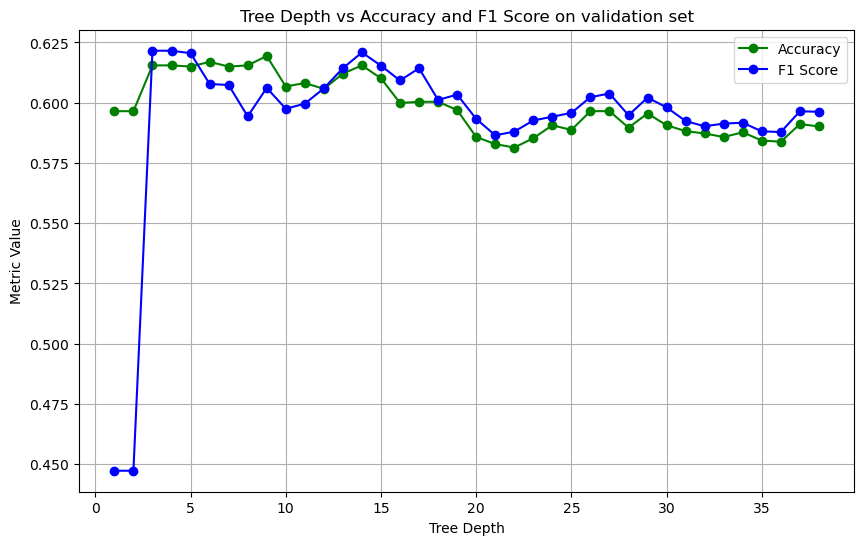

In [217]:
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, f1_score

def plot_depth_vs_metrics(model, X_train, y_train, X_val, y_val):
    """
    Plots accuracy and F1-score as a function of tree depth for a Decision Tree model.
    
    Args:
        model : A trained DecisionTreeClassifier (used to get max_depth).
        X_train : Training feature set.
        y_train : Training target values.
        X_val : Validation feature set.
        y_val : Validation target values.
    """
    # Get the maximum depth of the provided model
    max_depth = model.get_depth()
    
    # Initialize lists to store metrics
    depths = range(1, max_depth + 1)
    accuracies = []
    f1_scores = []

    # Loop through each depth and train the tree
    for depth in depths:
        # Define and train a new Decision Tree model with the current depth
        temp_model = DecisionTreeClassifier(random_state=7, max_depth=depth)
        temp_model.fit(X_train, y_train)
        
        
        # Predict on the validation set
        y_pred = temp_model.predict(X_val)
        
        # Calculate metrics
        accuracies.append(accuracy_score(y_val, y_pred))
        f1_scores.append(f1_score(y_val, y_pred))

    # Plot the metrics
    plt.figure(figsize=(10, 6))
    plt.plot(depths, accuracies, label="Accuracy", color="green", marker="o")
    plt.plot(depths, f1_scores, label="F1 Score", color="blue", marker="o")
    plt.xlabel("Tree Depth")
    plt.ylabel("Metric Value")
    plt.title("Tree Depth vs Accuracy and F1 Score on validation set")
    plt.legend()
    plt.grid(True)
    plt.show()
plot_depth_vs_metrics(model_tree, X_train, y_train, X_val, y_val)

In [218]:
model_tree = DecisionTreeClassifier(random_state=7, max_depth=3).fit(X_final_train, y_final_train)
y_pred = model_tree.predict(X_test)
print(classification_report(y_test, y_pred, digits=3))

              precision    recall  f1-score   support

           0      0.619     0.580     0.599      1026
           1      0.605     0.643     0.624      1026

    accuracy                          0.612      2052
   macro avg      0.612     0.612     0.611      2052
weighted avg      0.612     0.612     0.611      2052



In [219]:
print(export_text(model_tree, feature_names=X.columns, class_names=["won", "lost"]))

|--- shortest_path_length <= 1.33
|   |--- shortest_path_length <= -0.05
|   |   |--- shortest_path_length <= -1.42
|   |   |   |--- class: won
|   |   |--- shortest_path_length >  -1.42
|   |   |   |--- class: won
|   |--- shortest_path_length >  -0.05
|   |   |--- one_longer_path_count <= 0.96
|   |   |   |--- class: lost
|   |   |--- one_longer_path_count >  0.96
|   |   |   |--- class: won
|--- shortest_path_length >  1.33
|   |--- shortest_path_count <= 0.70
|   |   |--- shortest_path_length <= 2.69
|   |   |   |--- class: lost
|   |   |--- shortest_path_length >  2.69
|   |   |   |--- class: lost
|   |--- shortest_path_count >  0.70
|   |   |--- shortest_path_length <= 2.68
|   |   |   |--- class: lost
|   |   |--- shortest_path_length >  2.68
|   |   |   |--- class: lost



In [220]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
cm = confusion_matrix(y_test, y_pred)

print("Confusion Matrix:\n", cm)

Confusion Matrix:
 [[595 431]
 [366 660]]


## Correlation of inherent difficulty and given difficulty by noobs

Let's see if the predicted inherent difficulty correlates with the difficulty ratings given by noobs. We will use the trained logistic model to predict difficulty, scale it from 1 to 5 and compare it to given difficulties.

In [221]:
games_diff_ratings = games.copy()[games['newhashIP'].isin(noob_players)][['source_article', 'target_article', 'difficulty_rating', 'finished']]
games_diff_ratings.dropna(inplace=True)
games_diff_ratings['lost'] = games_diff_ratings['finished'].apply(lambda a: int(not a))
games_diff_ratings.drop(columns = ['finished'], inplace = True)
print(games_diff_ratings.shape[0])
games_diff_ratings.head()

3427


,source_article,target_article,difficulty_rating,lost
10,14th_century,Rainbow,4.0,0
32,2004_Atlantic_hurricane_season,Ice_age,1.0,0
34,2005_Atlantic_hurricane_season,Jazz,4.0,0
44,Aberdeen,Vampire_bat,3.0,0
47,Acceleration,Elephant,1.0,0


In [222]:
games_diff_ratings['lost'].describe()

count    3427.0
mean        0.0
std         0.0
min         0.0
25%         0.0
50%         0.0
75%         0.0
max         0.0
Name: lost, dtype: float64

In [223]:
games_diff_ratings = games_diff_ratings.set_index(['source_article', 'target_article'])
games_diff_ratings.index.names = ['source', 'target']
games_diff_ratings.head()

,,difficulty_rating,lost
source,target,,
14th_century,Rainbow,4.0,0
2004_Atlantic_hurricane_season,Ice_age,1.0,0
2005_Atlantic_hurricane_season,Jazz,4.0,0
Aberdeen,Vampire_bat,3.0,0
Acceleration,Elephant,1.0,0


In [224]:
useful_pair_data.head()

shortest_path_length  shortest_path_count  \
source       target                                                    
10th_century 10th_century                     0                    1   
             11th_century                     1                    1   
             12th_century                     2                    5   
             13th_century                     2                    4   
             14th_century                     2                    4   

                           one_longer_path_count  avg_sp_avg_node_degree  \
source       target                                                        
10th_century 10th_century                      0                       0   
             11th_century                      2                      13   
             12th_century                    121                      23   
             13th_century                    131                      28   
             14th_century                    113                      22   

                           max_ol_node_degree  
source       target                            
10th_century 10th_century                   0  
             11th_century                  62  
             12th_century                 180  
             13th_century                 169  
             14th_century                 169

In [225]:
X = games_diff_ratings.join(useful_pair_data)
X = X.astype(float)
X.head()

,,difficulty_rating,lost,shortest_path_length,shortest_path_count,one_longer_path_count,avg_sp_avg_node_degree,max_ol_node_degree
source,target,,,,,,,
14th_century,Rainbow,4.0,0.0,3.0,5.0,198.0,34.0,172.0
2004_Atlantic_hurricane_season,Ice_age,1.0,0.0,3.0,58.0,400.0,53.0,294.0
2005_Atlantic_hurricane_season,Jazz,4.0,0.0,2.0,1.0,113.0,116.0,294.0
Aberdeen,Vampire_bat,3.0,0.0,4.0,15.0,400.0,48.0,244.0
Acceleration,Elephant,1.0,0.0,3.0,6.0,197.0,55.0,294.0


In [226]:
# Add embedding information to the dataset for source and target articles
X = X.join(embeddings_df, on='source')
X.rename(columns={'embedding': 'source_embedding'}, inplace=True)
X = X.join(embeddings_df, on='target')
X.rename(columns={'embedding': 'target_embedding'}, inplace=True)

# Calculate the cosine similarity between the source and target article embeddings and drop the embeddings
X['cosine_similarity'] = X.apply(lambda x: np.dot(x['source_embedding'], x['target_embedding']) / (np.linalg.norm(x['source_embedding']) * np.linalg.norm(x['target_embedding'])), axis=1)
X.drop(columns=['source_embedding', 'target_embedding'], inplace=True)

X.head()

,,difficulty_rating,lost,shortest_path_length,shortest_path_count,one_longer_path_count,avg_sp_avg_node_degree,max_ol_node_degree,cosine_similarity
source,target,,,,,,,,
14th_century,Rainbow,4.0,0.0,3.0,5.0,198.0,34.0,172.0,0.395498
2004_Atlantic_hurricane_season,Ice_age,1.0,0.0,3.0,58.0,400.0,53.0,294.0,0.281696
2005_Atlantic_hurricane_season,Jazz,4.0,0.0,2.0,1.0,113.0,116.0,294.0,0.462522
Aberdeen,Vampire_bat,3.0,0.0,4.0,15.0,400.0,48.0,244.0,0.554146
Acceleration,Elephant,1.0,0.0,3.0,6.0,197.0,55.0,294.0,0.348239


In [227]:
X.dropna(inplace=True)
target_diff = X.copy()['difficulty_rating']
lost = X.copy()['lost']
X.drop(columns = ['difficulty_rating', 'lost'], inplace = True)
X.head()

,,shortest_path_length,shortest_path_count,one_longer_path_count,avg_sp_avg_node_degree,max_ol_node_degree,cosine_similarity
source,target,,,,,,
14th_century,Rainbow,3.0,5.0,198.0,34.0,172.0,0.395498
2004_Atlantic_hurricane_season,Ice_age,3.0,58.0,400.0,53.0,294.0,0.281696
2005_Atlantic_hurricane_season,Jazz,2.0,1.0,113.0,116.0,294.0,0.462522
Aberdeen,Vampire_bat,4.0,15.0,400.0,48.0,244.0,0.554146
Acceleration,Elephant,3.0,6.0,197.0,55.0,294.0,0.348239


In [228]:
lost_test = (lost*4)+1
(np.abs(lost_test-target_diff)).mean()

1.2348993288590604

The difference between scaled 'lost' column (scaled to 1-5) and difficulty given by noob users is in average 1.23.

In [229]:
X_data = scaler.transform(X)
inh_diff = model.predict(X_data)
print(classification_report(lost, (inh_diff > 0.49), digits=3))

              precision    recall  f1-score   support

         0.0      1.000     0.653     0.790      3427
         1.0      0.000     0.000     0.000         0

    accuracy                          0.653      3427
   macro avg      0.500     0.327     0.395      3427
weighted avg      1.000     0.653     0.790      3427



C:\Users\bgabe\miniconda3\envs\ada\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\bgabe\miniconda3\envs\ada\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\bgabe\miniconda3\envs\ada\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [230]:
inh_diff = (inh_diff*4)+1
(np.abs(target_diff-inh_diff)).mean()

0.981240402214589

The difference between predicted inherent difficulty (scaled to 1-5) and difficulty given by users is on average 0.98.

## Dividing people by skills